In [12]:


%matplotlib inline

##THIS IS FOR ACCESSING THE CONCORDE TSP SOLVER
from subprocess import Popen

import os
class tsp:
    def __init__(self, points=None):
        self.points = points if points else []
    def solve(self, filename='_tmp_'):
        with open('%s.dat' % filename, 'w') as fp:
            fp.write('TYPE : TSP\nDIMENSION : %d\n' % len(self.points))
            fp.write('EDGE_WEIGHT_TYPE : GEO\nNODE_COORD_SECTION\n')
            for i, (x, y) in enumerate(self.points):
                fp.write('%d %g %g\n' % (i, x, y))
            fp.write('EOF\n')
        prc = Popen('./concorde   -m %s.dat' % filename, shell=True)
        prc.wait()
        with open('%s.sol' % filename) as fp:
            ll = (''.join(fp)).split()
        self.result = [int(s) for s in ll[1:]]
        for s in ('%s.dat', '%s.sol'): os.remove(s % filename)

            
            

In [13]:
##THIS I FOR ACCESSING THE CONCORDE TSP SOLVER BZCKUP,SWITCHING TO GEO
#from subprocess import Popen
#import os
#class tsp:
#    def __init__(self, points=None):
#        self.points = points if points else []
#    def solve(self, filename='_tmp_'):
#        with open('%s.dat' % filename, 'w') as fp:
#            fp.write('TYPE : TSP\nDIMENSION : %d\n' % len(self.points))
#            fp.write('EDGE_WEIGHT_TYPE : EUC_2D\nNODE_COORD_SECTION\n')
#            for i, (x, y) in enumerate(self.points):
#                fp.write('%d %g %g\n' % (i, x, y))
#            fp.write('EOF\n')
#        prc = Popen('./concorde -m  %s.dat' % filename, shell=True)
#        prc.wait()
#        with open('%s.sol' % filename) as fp:
#            ll = (''.join(fp)).split()
#        self.result = [int(s) for s in ll[1:]]
#        for s in ('%s.dat', '%s.sol'): os.remove(s % filename)

In [14]:
import geopy
import pickle
import json
import pymongo
from geopy.distance import geodesic
#import musicbrainzngs
import arrow
from datetime import datetime
from pymongo import MongoClient
from collections import defaultdict
from dateutil import parser
from slugify import slugify
import math
from numbers import Number

# setup mongo
client = MongoClient()
db = client["bandstour"]
bandsintown =  db["bandsintown"]

# date parsing
DATETIME_FORMAT = '%Y-%m-%dT%H:%M:%S'
DATETIME_FORMAT_FOR_MSBNZ ='%Y-%m-%d'

#retrieve trip coords for each artist
dict_coords={}

import numpy as np
from matplotlib import pyplot as plt


In [16]:
#INITIALIZE

final_embeddings=[]
totalDists=0
totalOptDists=0
totalOptDistsMin=0
#for artist in db.minedArtists.find({ 'name' : 'David Guetta' }) :
#for artist in db.minedArtists.find({ 'name' : 'Vokab Kompany' }) :
#for artist in db.minedArtists.find({ 'name' : 'Ural Kosaken Chor' }) :
#for artist in db.minedArtists.find({ 'name' : 'Leo Kottke' }) :
#for artist in db.minedArtists.find({ 'name' : 'Björk' }) :
#for artist in db.minedArtists.find({ 'name' : 'Deerhoof' }) :
#for artist in db.minedArtists.find({ 'name' : 'Legends' }) :
#for artist in db.minedArtists.find({ 'name' : 'Laidback Luke' }) :
#for artist in db.minedArtists.find({ 'name' : 'Andy Moor' }) :
#for artist in db.minedArtists.find({ 'name' : 'Mia' }) :
#for artist in db.minedArtists.find({ 'name' : 'Dead Kennedys' }) :
#for artist in db.minedArtists.find({ 'name' : 'House of Pain' }) :
for artist in db.minedArtists.find(no_cursor_timeout=True) :
#LOOP THROUGH ALL ARTISTS IN BASE AND CALCULATE OPTIMIZED PARAMETER
 if os.path.exists("./tour_miner/"+slugify(artist["name"]+str(artist["mbid"]))+".obj")==True:
        print "SKIPPED",artist["name"]
        #print slugify(artist["name"])
        with open("./tour_miner/"+slugify(artist["name"]+str(artist["mbid"]))+".obj", 'rb') as handle:
          temp= pickle.load( handle)
        #print temp
        tmppp =0
        
        totalArtistTourDist=0
        totalArtistOptTourDist=0
        totalArtistTourDist=temp["totalArtistTourDist"]
        totalArtistOptTourDist=temp["totalArtistOptTourDist"]
        
        totalDists+=totalArtistTourDist
        totalOptDists+=totalArtistOptTourDist
        if float(totalArtistTourDist) <= float(totalArtistOptTourDist)      :  
            tmppp=float(totalArtistTourDist)
        else:
            tmppp=float(totalArtistOptTourDist)
        totalOptDistsMin+=tmppp
        #print totalArtistTourDist," / ",totalArtistOptTourDist
        #print totalDists," / ",totalOptDists," / ",totalOptDistsMin," / ",tmppp
        
        #pass
 else:
    

    results={}
    tourindice=0
    results["name"]=artist["name"]
    print artist["name"]
    totalArtistTourDist=0
    totalArtistOptTourDist=0
    for tour in artist["tours"]:
        #print tour["gigs"][0]["datetime"].year
        #print tour["gigs"][-1]["datetime"].year
        #print int(math.ceil(len(tour["gigs"])/2))
        tourCoords= []
        tourdist=0
        tourdistOpt=0
        tourdistOpt2=0
        tourdistOpt3=0
        tourLength=0
        tourYear=0
        tourYearStart=0
        tourYearEnd=0
        tourYearMid=0
        t=0
        #print len(tour["tourCoords"])
        if len(tour["tourCoords"])>2:
         tourLength=int(math.ceil(len(tour["gigs"])))
         if tourLength > 365:
                print tourLength
         if tourLength>0:
            tourYearStart=tour["gigs"][0]["datetime"].year
            tourYearEnd=tour["gigs"][-1]["datetime"].year
            if tourYearStart == tourYearEnd :
                tourYear= tourYearStart
            else:
                tourYearMid= tourYearEnd=tour["gigs"][int(math.ceil(len(tour["gigs"])/2))]["datetime"].year
                if tourYearStart == tourYearMid :
                    tourYear= tourYearStart
                else:
                    tourYear= tourYearEnd
            
            tourindice+=1
            #print  tour["tourCoords"]
            ###[0] for quick fix
            tourCoords=[tuple(tourCoord[0]) for tourCoord in tour["tourCoords"]]
            #print tourCoords
            ###RERUN OPT,PICKING BETTER SOLUTION
            t=tsp(tourCoords)
            #print t
            t.solve()
            #print "here"

            #print t.result
            #print t.points
            #print "long",len (t.result)
            i = 0
            while i < len (t.result)-1:
                res=t.result[i]
                res2=t.result[i+1]
                #print vincenty(t.points[res],t.points[res2]).kilometers
                tourdistOpt= tourdistOpt + geodesic(t.points[res],t.points[res2]).kilometers
                
                
                i+=1
            
            j = 0
            while j < len (tourCoords)-1:
                
                #print vincenty(t.points[res],t.points[res2]).kilometers
                tourdist= tourdist + geodesic(tourCoords[j],tourCoords[j+1]).kilometers
                j+=1
            
            #print "DEFAULT TOUR DIST",tourdist
            #print "TOURDISTOPTIMIZED",tourdistOpt
            totalArtistTourDist+=tourdist
            totalArtistOptTourDist+=tourdistOpt
            results[tourindice]={'tourdist':tourdist,'tourdistOpt':tourdistOpt,'tourLength' : tourLength , 'tourYear': tourYear}
    #print results
    tourInd=0
    resultsYears={}
    for tourInd in results:
     #print tourInd
        #if tourInd != 'name ':
     if isinstance(tourInd, Number):
        """"reduce dataset to its relevant years !!!! 
        1990 / Nb de groupes comptabilisés cette année / 1
1991 / Nb de groupes comptabilisés cette année / 1
1992 / Nb de groupes comptabilisés cette année / 3
1993 / Nb de groupes comptabilisés cette année / 1
1994 / Nb de groupes comptabilisés cette année / 2
1995 / Nb de groupes comptabilisés cette année / 2
1996 / Nb de groupes comptabilisés cette année / 2
1997 / Nb de groupes comptabilisés cette année / 8
1998 / Nb de groupes comptabilisés cette année / 2
1999 / Nb de groupes comptabilisés cette année / 15
2000 / Nb de groupes comptabilisés cette année / 4
2001 / Nb de groupes comptabilisés cette année / 1
2002 / Nb de groupes comptabilisés cette année / 3
2003 / Nb de groupes comptabilisés cette année / 7
2004 / Nb de groupes comptabilisés cette année / 10
2005 / Nb de groupes comptabilisés cette année / 17
2006 / Nb de groupes comptabilisés cette année / 22
2007 / Nb de groupes comptabilisés cette année / 2719
2008 / Nb de groupes comptabilisés cette année / 4101
2009 / Nb de groupes comptabilisés cette année / 5447
2010 / Nb de groupes comptabilisés cette année / 7083
2011 / Nb de groupes comptabilisés cette année / 6965
2012 / Nb de groupes comptabilisés cette année / 11048
2013 / Nb de groupes comptabilisés cette année / 13451
2014 / Nb de groupes comptabilisés cette année / 16331
2015 / Nb de groupes comptabilisés cette année / 20790
2016 / Nb de groupes comptabilisés cette année / 25322
2017 / Nb de groupes comptabilisés cette année / 25302
2018 / Nb de groupes comptabilisés cette année / 475
2019 / Nb de groupes comptabilisés cette année / 1)
          if results[tourInd]['tourYear'] >= 2007 and results[tourInd]['tourYear'] <= 2017:"""
        #print resultsYears
        #print results
        #print tourInd
        #print results[tourInd]['tourYear']
        if results[tourInd]['tourYear'] not in resultsYears:
              
                resultsYears[results[tourInd]['tourYear']]={'toursCount':0,'toursDist':0,'toursDistOpt':0,'toursLength':0}
            
        resultsYears[results[tourInd]['tourYear']]['toursCount']+=1
        resultsYears[results[tourInd]['tourYear']]['toursDist']=resultsYears[results[tourInd]['tourYear']]['toursDist']+results[tourInd]['tourdist']
        resultsYears[results[tourInd]['tourYear']]['toursDistOpt']=resultsYears[results[tourInd]['tourYear']]['toursDistOpt']+results[tourInd]['tourdistOpt']
        resultsYears[results[tourInd]['tourYear']]['toursLength']=resultsYears[results[tourInd]['tourYear']]['toursLength']+results[tourInd]['tourLength']
            
    #print resultsYears
    statNbYear=len(resultsYears)
    statMeanYearDist=0
    statMeanDistOpt=0
    statMeanYeartoursLength=0
    statMeanYeartoursCount=0
    #Calculating means
    for Year in resultsYears:
        statMeanYearDist+=resultsYears[Year]['toursDist']
        statMeanDistOpt+=resultsYears[Year]['toursDistOpt']
        statMeanYeartoursLength+=resultsYears[Year]['toursLength']
        statMeanYeartoursCount+=resultsYears[Year]['toursCount']
    #print statMeanYearDist
    #print statNbYear
    if statMeanYearDist > 0:
        statMeanYearDist=statMeanYearDist/statNbYear
        statMeanDistOpt=statMeanDistOpt/statNbYear
        statMeanYeartoursLength=statMeanYeartoursLength/statNbYear
        statMeanYeartoursCount=statMeanYeartoursCount/statNbYear
        resultsYears['statMeanYearDist']=statMeanYearDist
        resultsYears['statMeanYearDistOpt']=statMeanDistOpt
        resultsYears['statMeanYeartoursLength']=statMeanYeartoursLength
        resultsYears['statMeanYeartoursCount']=statMeanYeartoursCount
        resultsYears['statNbYear']=statNbYear
        
        for Year in resultsYears:
            if isinstance(Year, Number):
                #print Year
                resultsYears[Year]['stattoursDist']=float(resultsYears[Year]['toursDist']-resultsYears['statMeanYearDist'])/resultsYears['statMeanYearDist']
                resultsYears[Year]['stattoursDistOpt']=float(resultsYears[Year]['toursDistOpt']-resultsYears['statMeanYearDistOpt'])/resultsYears['statMeanYearDistOpt']
                resultsYears[Year]['stattoursLength']=float(resultsYears[Year]['toursLength']-resultsYears['statMeanYeartoursLength'])/resultsYears['statMeanYeartoursLength']
                resultsYears[Year]['stattoursCount']=float(resultsYears[Year]['toursCount']-resultsYears['statMeanYeartoursCount'])/resultsYears['statMeanYeartoursCount']
    
        
        
    #print "TOTAL DEFAULT ARTIST TOURS DISTS",totalArtistTourDist
    #print "TOTAL OPTIMIZED ARTIST TOURS DISTS",totalArtistOptTourDist 
    if totalArtistTourDist > 0 :
        OptArtistPercent=0
        OptArtistPercent=100 *(totalArtistTourDist-totalArtistOptTourDist) / totalArtistTourDist
        results["OptArtistPercent"]=OptArtistPercent
        #print "OPTIMIZED BY ", OptArtistPercent," %"
    #print"_______________________________"
    totalDists+=totalArtistTourDist
    totalOptDists+=totalArtistOptTourDist
    tmppp=0
    if float(totalArtistTourDist) <= float(totalArtistOptTourDist)      :  
            tmppp=float(totalArtistTourDist)
    else:
            tmppp=float(totalArtistOptTourDist)
    totalOptDistsMin+=tmppp
    
    results["resultsYears"]=resultsYears
    results["totalArtistTourDist"]=totalArtistTourDist
    results["totalArtistOptTourDist"]=totalArtistOptTourDist
    
    with open("./tour_miner/"+slugify(artist["name"]+str(artist["mbid"]))+".obj", 'wb') as handle:
                            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #print results['resultsYears']
    #print totalDists," / ",totalArtistTourDist," / ",totalArtistOptTourDist," / ",totalOptDistsMin," / ",tmppp
print "***************************"
print "TOTAL ARTISTS TOURS DISTS",totalDists
print "TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS",totalOptDists 
print "TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS",totalOptDistsMin 
print "AUTO-OPTIMIZED BY ", 100 *(totalDists-totalOptDists) / totalDists," %"
print "MANUALLY OPTIMIZED BY ", 100 *(totalDists-totalOptDistsMin) / totalDists," %"
print "***************************"
with open("./RESULTSGLOBAL.obj", 'wb') as handle:
                            pickle.dump({"totalDists":totalDists,"totalOptDists":totalOptDists,"totalOptDistsMin":totalOptDistsMin,"autoOpt":(totalDists-totalOptDists) / totalDists,"manOpt":(totalDists-totalOptDistsMin) / totalDists}, handle, protocol=pickle.HIGHEST_PROTOCOL)

SKIPPED  Adestria, Erra
SKIPPED  Joey Cape, Jon Snodgrass & Brian Wahlstrom
SKIPPED  Phil Campbell and the Bastard Sons
SKIPPED !!!
SKIPPED "Acoustic Africa"
SKIPPED "Scream The Prayer"
SKIPPED #1 Dads
SKIPPED #PushYourDrumming/RolandVDrums
SKIPPED $uicideboy$
SKIPPED $wingin' Utter$
SKIPPED & The Shudderbugs
SKIPPED '77
SKIPPED 'Stache!
SKIPPED 'Thee' Duke of Dark
SKIPPED (de)absolve
SKIPPED (həd) p.e.
SKIPPED ...And You Will Know Us by the Trail of Dead
SKIPPED .38 Special
SKIPPED 070 SHAKE
SKIPPED 070shake
SKIPPED 0phe1ia
SKIPPED 1 Last Chance
SKIPPED 1-800 DINOSAUR
SKIPPED 10 String Symphony
SKIPPED 10 Years
SKIPPED 10,000 Maniacs
SKIPPED 100 Proof
SKIPPED 1000 Miles of Fire
SKIPPED 1000Mods
SKIPPED 1001
SKIPPED 10cc
SKIPPED 112
SKIPPED 11th Hour
SKIPPED 12
SKIPPED 12 Stones
SKIPPED 12th Planet
SKIPPED 13 Scars
SKIPPED 1349
SKIPPED 138
SKIPPED 14
SKIPPED 15
SKIPPED 16
SKIPPED 1605
SKIPPED 16BIT
SKIPPED 17
SKIPPED 17 Hippies
SKIPPED 1776
SKIPPED 182 - UK Tribute Act To Blink 182
SKI

SKIPPED Aaron Einhouse
SKIPPED Aaron English
SKIPPED Aaron Gibson
SKIPPED Aaron Goldberg
SKIPPED Aaron Heick - sax
SKIPPED Aaron Kamm and the One Drops
SKIPPED Aaron Keylock
SKIPPED Aaron Lee Tasjan
SKIPPED Aaron Lewis
SKIPPED Aaron Liberator
SKIPPED Aaron Neville
SKIPPED Aaron Parks
SKIPPED Aaron Roche
SKIPPED Aaron Shust
SKIPPED Aaron Stephens
SKIPPED Aaron Tippin
SKIPPED Aaron Watson
SKIPPED Aaron West and The Roaring Twenties
SKIPPED Aaron Wilburn
SKIPPED Aaron Woodall Comedy
SKIPPED Aaron Woods Band
SKIPPED Aazar
SKIPPED Ab-Soul
SKIPPED Aba Shanti-I
SKIPPED Abacabb
SKIPPED Abacinate
SKIPPED Abacus
SKIPPED Abandoman
SKIPPED Abandon
SKIPPED Abandon All Ships!
SKIPPED Abandon The Midwest
SKIPPED Abandoned By Bears
SKIPPED Abba Gold
SKIPPED Abba the Concert
SKIPPED AbbaFab
SKIPPED Abbacadabra - The Ultimate ABBA Tribute
SKIPPED Abbamania
SKIPPED Abbath -Official-
SKIPPED Abbey Road Tribute
SKIPPED Abbot Kinney
SKIPPED Abd al Malik
SKIPPED Abdominal
SKIPPED Abdoulaye Diabate
SKIPPED Ab

SKIPPED Alexis Gomez
SKIPPED Alexis HK
SKIPPED Alexis Keegan
SKIPPED Alexis Taylor
SKIPPED Alexisonfire
SKIPPED Alexkid
SKIPPED Alexz Johnson
SKIPPED Alfa
SKIPPED Alfa Rococo
SKIPPED Alfie Boe
SKIPPED Alfred Banks
SKIPPED Alfred Heinrichs
SKIPPED Alfredo
SKIPPED Alfredo Olivas
SKIPPED Alfredo Rodríguez
SKIPPED Algiers
SKIPPED Ali Campbell
SKIPPED Ali Holder
SKIPPED Ali Jackson
SKIPPED Ali Laz
SKIPPED Ali Rose
SKIPPED Ali Shaheed Muhammad
SKIPPED Ali Wong
SKIPPED Ali Zafar
SKIPPED Alibi
SKIPPED Alican
SKIPPED Alice & The Wonders
SKIPPED Alice Bag
SKIPPED Alice Cooper
SKIPPED Alice D
SKIPPED Alice Dimicele
SKIPPED Alice Drinks the Kool Aid
SKIPPED Alice Phoebe Lou
SKIPPED Alice Russell
SKIPPED Alice Smith
SKIPPED Alice Un Chained
SKIPPED Alice Wallace
SKIPPED Alice in Chains
SKIPPED Alice in Wonderland
SKIPPED Alicia Olatuja
SKIPPED Alicia Witt
SKIPPED Alien Ant Farm
SKIPPED Alien Knife Fight
SKIPPED Alien Rain
SKIPPED Aliji
SKIPPED Alika & Nueva Alianza
SKIPPED Alin Coen
SKIPPED Alina B

SKIPPED Angelo Debarre
SKIPPED Angelos
SKIPPED Angels
SKIPPED Angels & Airwaves
SKIPPED Angelspit
SKIPPED Angelus Apatrida
SKIPPED Angelz
SKIPPED Angemi
SKIPPED Anger as Art
SKIPPED Angerfist
SKIPPED Angie
SKIPPED Angie Atkinson
SKIPPED Angie Brown
SKIPPED Angie Keilhauer
SKIPPED Angra
SKIPPED Angus Munro
SKIPPED Angus Tarnawsky
SKIPPED Angwish
SKIPPED Angèle
SKIPPED Angélique Kidjo
SKIPPED Ani DiFranco
SKIPPED Ania Dąbrowska
SKIPPED Ania Wyszkoni
SKIPPED Anialator
SKIPPED Anika Kunst
SKIPPED Anima
SKIPPED Animal Collective
SKIPPED Animal Flag
SKIPPED Animal Trainer
SKIPPED Animal Years
SKIPPED Animals Killing People
SKIPPED Animals and Friends
SKIPPED Animals as Leaders
SKIPPED Animato
SKIPPED Animotion
SKIPPED Animus
SKIPPED Anita
SKIPPED Anita Cochran
SKIPPED Anita Renfroe
SKIPPED Anita Ward
SKIPPED Anizoba
SKIPPED Anja Augner
SKIPPED Anja Schneider
SKIPPED Anjelah Johnson
SKIPPED Anjunabeats
SKIPPED Anklepants
SKIPPED Ann Clue
SKIPPED Ann Hampton Callaway
SKIPPED Ann Nesby
SKIPPED 

SKIPPED Avatarium
SKIPPED Avec Sans
SKIPPED Avenged Sevenfold
SKIPPED Aventurera
SKIPPED Avenues
SKIPPED Average White Band
SKIPPED Avers
SKIPPED Aversions Crown
SKIPPED Avery Sunshine
SKIPPED Avi Avital
SKIPPED Avi Buffalo
SKIPPED Avi Sic
SKIPPED Aviator
SKIPPED Avicii
SKIPPED Avion Roe
SKIPPED Avishai Cohen
SKIPPED Aviva Jaye
SKIPPED Avon Dale
SKIPPED Avíon Blackman
SKIPPED Awa Ly
SKIPPED Await Rescue
SKIPPED Awake at last
SKIPPED Awaken
SKIPPED Awaken the Empire
SKIPPED Awe
SKIPPED Aweminus
SKIPPED Awesome Tapes From Africa
SKIPPED Awir Leon
SKIPPED AxH
SKIPPED Axe Murder Boyz
SKIPPED Axel Bauer
SKIPPED Axel Boman
SKIPPED Axel Prahl
SKIPPED Axel Ritt
SKIPPED Axel Rudi Pell
SKIPPED Axel Zwingenberger
SKIPPED Axes
SKIPPED Axis
SKIPPED Axis:Sova
SKIPPED Axwell
SKIPPED Aya
SKIPPED Aycee Lovely
SKIPPED Ayiesha Woods
SKIPPED Ayla Brown
SKIPPED Ayla Nereo
SKIPPED Aymeric MAINI
SKIPPED Aynsley Lister
SKIPPED Ayo
SKIPPED Ayo Jay
SKIPPED Ayreheart
SKIPPED Azad
SKIPPED Azar Lawrence
SKIPPED Az

SKIPPED Before The Flood
SKIPPED Before the Streetlights
SKIPPED Begat The Nephilim
SKIPPED Beginner
SKIPPED Beginners
SKIPPED Beheaded
SKIPPED Behexen
SKIPPED Behind Deadlines
SKIPPED Behind The Façade
SKIPPED Behind the Fallen
SKIPPED Behind the Screen
SKIPPED Behind the Sun
SKIPPED Behold the Brave
SKIPPED Behrouz
SKIPPED Behzod ABDURAÏMOV
SKIPPED Being As An Ocean
SKIPPED Beirut
SKIPPED Beitthemeans
SKIPPED Beki Brindle Scala
SKIPPED Bel Airs
SKIPPED Bela B.
SKIPPED Bela Fleck and Abigail Washburn
SKIPPED Belanova
SKIPPED Beleaf Melanin
SKIPPED Belgium
SKIPPED Belial
SKIPPED Beliefs
SKIPPED Believe
SKIPPED Belinda
SKIPPED Belinda Carlisle
SKIPPED Bell Biv DeVoe
SKIPPED Bell Witch
SKIPPED Bell X1
SKIPPED Bella Ciao
SKIPPED Bella Donna-A Tribute to Stevie Nicks and Fleetwood Mac
SKIPPED Bella Hardy
SKIPPED Bella Morte
SKIPPED Bella Novela
SKIPPED Bella Sarris
SKIPPED Bella's Bartok
SKIPPED Bellamy Brothers Band
SKIPPED Bellator MMA
SKIPPED Belle Adair
SKIPPED Belle Chen, Pianist -陳佳貝

SKIPPED Black Pistol Fire
SKIPPED Black Powder
SKIPPED Black Prairie
SKIPPED Black Pussy
SKIPPED Black Rebel Motorcycle Club
SKIPPED Black Rheno
SKIPPED Black Roots
SKIPPED Black Sabbath
SKIPPED Black Sabbitch
SKIPPED Black Sheep
SKIPPED Black Slate
SKIPPED Black Spiders
SKIPPED Black Star
SKIPPED Black Star Riders
SKIPPED Black Stone Cherry
SKIPPED Black Sun Empire
SKIPPED Black Swift
SKIPPED Black Tar Prophet
SKIPPED Black Taxi
SKIPPED Black Thought
SKIPPED Black Tide
SKIPPED Black Tiger Sex Machine
SKIPPED Black Tongue
SKIPPED Black Tooth Grin
SKIPPED Black Trip
SKIPPED Black Tusk
SKIPPED Black Uhuru
SKIPPED Black Valentine
SKIPPED Black Veil Brides
SKIPPED Black Velvet
SKIPPED Black Violin
SKIPPED Black Water (Hardcore)
SKIPPED Black Widows
SKIPPED Black Witchery
SKIPPED Black Wizard
SKIPPED Black-Bone
SKIPPED BlackDiamond
SKIPPED BlackGummy
SKIPPED BlackJack
SKIPPED BlackRain
SKIPPED BlackRose
SKIPPED BlackWaters
SKIPPED Blackalicious
SKIPPED Blackballed
SKIPPED Blackbear
SKIPPED 

SKIPPED Boz Scaggs
SKIPPED Bracewar
SKIPPED Brackish Water Jamboree
SKIPPED Brad Brock
SKIPPED Brad Brooks
SKIPPED Brad Cole
SKIPPED Brad Dear
SKIPPED Brad Garrett
SKIPPED Brad Goode
SKIPPED Brad Leali
SKIPPED Brad Mehldau
SKIPPED Brad Paisley
SKIPPED Brad Parsons
SKIPPED Brad Ray Songs
SKIPPED Brad Stine
SKIPPED Brad Upton
SKIPPED Brad Wells
SKIPPED Brad Williams
SKIPPED Brad Wilson
SKIPPED Bradley Banning
SKIPPED Bradley Carter Music
SKIPPED Bradley Hathaway
SKIPPED Bradley Sherrer
SKIPPED Brady
SKIPPED Brady Rymer & The Little Band That Could
SKIPPED Brady Toops
SKIPPED Brady Watt
SKIPPED Braid
SKIPPED Braiden Sunshine
SKIPPED Braids
SKIPPED Braille
SKIPPED Brain Bagz
SKIPPED Brain Damage
SKIPPED Brain Dead
SKIPPED Brain Tentacles
SKIPPED Brains
SKIPPED Brainstorm
SKIPPED Brainstory
SKIPPED Branan Murphy
SKIPPED Branches
SKIPPED Branchez
SKIPPED Brand
SKIPPED Brand New
SKIPPED Brand Nubian
SKIPPED Brand X
SKIPPED Brand of Julez
SKIPPED Branded
SKIPPED Branden James
SKIPPED Brandi Ca

SKIPPED Busdriver
SKIPPED Bush
SKIPPED Bushido
SKIPPED Busman's Holiday
SKIPPED Busta Flex
SKIPPED Busta Rhymes
SKIPPED Busted
SKIPPED Buster - rock duo
SKIPPED Buster Poindexter
SKIPPED Buster Shuffle
SKIPPED Buster Williams
SKIPPED Busty and the Bass
SKIPPED Butane
SKIPPED Butch
SKIPPED Butch Clancy
SKIPPED Butch Trucks And The Freight Train Band
SKIPPED Butch Walker
SKIPPED Butcher Babies
SKIPPED Butcher Brown
SKIPPED Butchered
SKIPPED Butta
SKIPPED Butter
SKIPPED Buttercup
SKIPPED Butterflies
SKIPPED Butterfly
SKIPPED Buttering Trio
SKIPPED Butterscotch
SKIPPED Buvette
SKIPPED Buxton
SKIPPED Buyepongo
SKIPPED Buzzard
SKIPPED Buzzcocks
SKIPPED By Light We Loom
SKIPPED By Starlight
SKIPPED By The Rivers
SKIPPED By the Thousands
SKIPPED Bye Bye Baby
SKIPPED Byrne and Kelly
SKIPPED Byron Hill
SKIPPED Byron Stingily
SKIPPED Byron Stripling
SKIPPED Byzantine
SKIPPED BÉJART BALLET LAUSANNE
SKIPPED BÖLZER
SKIPPED BØRNS
SKIPPED Bâton bleu
SKIPPED Bäer
SKIPPED Békar et les Imposteurs
SKIPPED

SKIPPED Catch22
SKIPPED CatchingYourClouds
SKIPPED Caterpillars
SKIPPED Caterwall
SKIPPED Catfish
SKIPPED Catfish Keith
SKIPPED Cath
SKIPPED Catharsis
SKIPPED Catherine Ringer
SKIPPED Catherine Russell
SKIPPED Catholic Action
SKIPPED Cathy Fink
SKIPPED Cathy Richardson
SKIPPED Catrin Finch
SKIPPED Cattle
SKIPPED Cattle Decapitation
SKIPPED Catz N Dogz
SKIPPED Caught A Ghost
SKIPPED Cauldron
SKIPPED Cause 4 Concern
SKIPPED Caustic
SKIPPED Caustic Casanova
SKIPPED Caustic Method
SKIPPED Caution
SKIPPED Cautioners
SKIPPED Cavalcade
SKIPPED Cavale
SKIPPED Cavalera Conspiracy
SKIPPED Cavalia
SKIPPED Cavalier
SKIPPED Cavalleria Rusticana
SKIPPED Cave Clove
SKIPPED Cave of Swimmers
SKIPPED Caveat
SKIPPED Caveman
SKIPPED Cavern
SKIPPED Caves (CAN)
SKIPPED Cavum
SKIPPED Caye
SKIPPED Cayetana
SKIPPED Cayucas
SKIPPED Cazador
SKIPPED Cazzette
SKIPPED CeCe Winans
SKIPPED CeU
SKIPPED Cease
SKIPPED Cecil Otter
SKIPPED Cedric Gervais
SKIPPED Cedric Maison
SKIPPED Cedric the Entertainer
SKIPPED Cee-Lo


SKIPPED Chris Wood
SKIPPED Chris Young
SKIPPED Chris de Burgh
SKIPPED Chris keys
SKIPPED Chris von B.
SKIPPED ChrisVoss
SKIPPED Chrisette Michele
SKIPPED Chrissi Poland
SKIPPED Chrissy
SKIPPED Christa Burch
SKIPPED Christafari
SKIPPED Christelle Durandy
SKIPPED Christian Alexander
SKIPPED Christian Burkhardt
SKIPPED Christian Castro
SKIPPED Christian Davis Music
SKIPPED Christian Death
SKIPPED Christian Evanko & Company
SKIPPED Christian Finnegan
SKIPPED Christian Howes
SKIPPED Christian Ingebrigtsen
SKIPPED Christian Kjellvander
SKIPPED Christian Lee Hutson
SKIPPED Christian Lopez
SKIPPED Christian Löffler
SKIPPED Christian Martin
SKIPPED Christian McBride
SKIPPED Christian Pincock Music
SKIPPED Christian Ryan Music
SKIPPED Christian Sands
SKIPPED Christian Schönberg
SKIPPED Christian Scott
SKIPPED Christian Smith
SKIPPED Christian Tiger School
SKIPPED Christian Vander
SKIPPED Christian-Pierre La Marca
SKIPPED Christiane Noll
SKIPPED Christiane Rösinger
SKIPPED Christie Huff Music
SKI

SKIPPED Consider the Source
SKIPPED Consortium
SKIPPED Consoul
SKIPPED Conspiracy
SKIPPED Conspiracy of Beards
SKIPPED Conspirator
SKIPPED Constantine Maroulis
SKIPPED Constellations
SKIPPED Construct (UK)
SKIPPED Consumed by Fire
SKIPPED Contact
SKIPPED Container
SKIPPED Contaminant
SKIPPED Contessa
SKIPPED Continental
SKIPPED Contra
SKIPPED Contrazt
SKIPPED Control
SKIPPED Control This
SKIPPED Controlled Collapse
SKIPPED Controller
SKIPPED Contrvbvnd
SKIPPED Converge
SKIPPED Conveyer
SKIPPED Convictions
SKIPPED Convicts
SKIPPED Convoy
SKIPPED Conway
SKIPPED Cooder Graw
SKIPPED Cooh
SKIPPED Cookie
SKIPPED Cookie Monsta
SKIPPED Cookie Rabinowitz
SKIPPED Cookies
SKIPPED Cookin' on 3 Burners
SKIPPED Cooking
SKIPPED Cool American
SKIPPED Cool Ghouls
SKIPPED Cool Kids
SKIPPED Coolio
SKIPPED Coone
SKIPPED Cooper Saver
SKIPPED Cope
SKIPPED Copeland
SKIPPED Copia
SKIPPED Coppelia
SKIPPED Copper
SKIPPED Copper Chief
SKIPPED Copyrights
SKIPPED Copywrite
SKIPPED Coral Creek
SKIPPED Corb Lund
SKI

SKIPPED DJ Dara
SKIPPED DJ Darko
SKIPPED DJ Darku J
SKIPPED DJ Dave Paul
SKIPPED DJ David Asko
SKIPPED DJ David Bailey
SKIPPED DJ David S. Fan Page
SKIPPED DJ Dawson
SKIPPED DJ Dee
SKIPPED DJ Dee Kline
SKIPPED DJ Diamond Fan Page
SKIPPED DJ Dibiase
SKIPPED DJ Die
SKIPPED DJ Digital Dave
SKIPPED DJ Dolo
SKIPPED DJ Donnie D
SKIPPED DJ DubPlates
SKIPPED DJ Duke
SKIPPED DJ Dynamix
SKIPPED DJ E-Rock
SKIPPED DJ EDGAR VELAZQUEZ
SKIPPED DJ ENUFF HH
SKIPPED DJ EU
SKIPPED DJ EZ
SKIPPED DJ Earl
SKIPPED DJ Elliott Estes
SKIPPED DJ Enjay
SKIPPED DJ Envy
SKIPPED DJ Erazer
SKIPPED DJ Exclusive
SKIPPED DJ FRA
SKIPPED DJ FRANZEN
SKIPPED DJ Falcon
SKIPPED DJ Fergie
SKIPPED DJ Ferno
SKIPPED DJ Five
SKIPPED DJ Flip
SKIPPED DJ Flipside
SKIPPED DJ Foksen
SKIPPED DJ Format
SKIPPED DJ Format- DJ Set
SKIPPED DJ Franky
SKIPPED DJ Freddy Bello
SKIPPED DJ Fresh
SKIPPED DJ Fresh Direct
SKIPPED DJ Fudge
SKIPPED DJ Funk
SKIPPED DJ Fuze
SKIPPED DJ GIOBAMA!
SKIPPED DJ GUV
SKIPPED DJ Ghost
SKIPPED DJ Gibson Praise
SKIP

SKIPPED Dana Buoy
SKIPPED Dana Carvey
SKIPPED Dana Cooper
SKIPPED Dana Dane
SKIPPED Dana Falconberry
SKIPPED Dana Fuchs
SKIPPED Dana Gould
SKIPPED Dana Hall
SKIPPED Dana Louise and the Glorious Birds
SKIPPED Dana Ruh
SKIPPED Dana T
SKIPPED Danakil
SKIPPED Danava
SKIPPED Danay Suarez
SKIPPED Dance Floor Riot
SKIPPED Dance Gavin Dance
SKIPPED Dance Laury Dance
SKIPPED Dance Spirit
SKIPPED Dance Yourself Clean
SKIPPED Dance a la plage
SKIPPED Danceperados Of Ireland
SKIPPED Danceteria
SKIPPED Dancing Queen
SKIPPED Dancing with The Stars
SKIPPED Dandu
SKIPPED Dane
SKIPPED Dane Drewis Music
SKIPPED Dane Page
SKIPPED Danga
SKIPPED Danger
SKIPPED Danger Danger
SKIPPED Danger Scene
SKIPPED Dangerbird
SKIPPED Dangermaker
SKIPPED Dangermuffin
SKIPPED Dangerous Toys
SKIPPED Dangers
SKIPPED Dani
SKIPPED Dani Casarano
SKIPPED Dani Filth
SKIPPED Dani Jack
SKIPPED Dani Martín
SKIPPED Dani Sbert
SKIPPED Dani Wilde
SKIPPED Daniel Ash
SKIPPED Daniel Avery
SKIPPED Daniel Bachman
SKIPPED Daniel Baughman
S

SKIPPED Dead Label!
SKIPPED Dead Leaf Echo
SKIPPED Dead Leaves
SKIPPED Dead Letter Circus
SKIPPED Dead Like Juliet
SKIPPED Dead Lord
SKIPPED Dead Man
SKIPPED Dead Man Winter
SKIPPED Dead Mans Party
SKIPPED Dead Meadow
SKIPPED Dead Poet Society
SKIPPED Dead Rabbits
SKIPPED Dead Rabbitts
SKIPPED Dead Radio
SKIPPED Dead Reckoning
SKIPPED Dead Ringer
SKIPPED Dead Rites
SKIPPED Dead Rock West
SKIPPED Dead Sara
SKIPPED Dead Sea
SKIPPED Dead Sea Skulls
SKIPPED Dead Sessions
SKIPPED Dead Set
SKIPPED Dead Soft
SKIPPED Dead Soldiers
SKIPPED Dead Stars
SKIPPED Dead Superstar
SKIPPED Dead Swords
SKIPPED Dead To A Dying World
SKIPPED Dead Weight 
SKIPPED Dead Winter Carpenters
SKIPPED Dead Words
SKIPPED Dead by April
SKIPPED Dead by Wednesday
SKIPPED Dead in 5
SKIPPED Dead to Fall
SKIPPED Dead to Me
SKIPPED Dead!
SKIPPED DeadPhish Orchestra
SKIPPED Deadbeat
SKIPPED Deadeye
SKIPPED Deadgrass
SKIPPED Deadheads
SKIPPED Deadhorse
SKIPPED Deadlies
SKIPPED Deadlock
SKIPPED Deadman
SKIPPED Deadman's Hand


SKIPPED Dirty Dirty
SKIPPED Dirty Dishes
SKIPPED Dirty Doering
SKIPPED Dirty Dozen
SKIPPED Dirty Few
SKIPPED Dirty Heads
SKIPPED Dirty Honkers
SKIPPED Dirty Kid Discount
SKIPPED Dirty Kitchen
SKIPPED Dirty Loops
SKIPPED Dirty Nil
SKIPPED Dirty Projectors
SKIPPED Dirty Revival
SKIPPED Dirty Saffi
SKIPPED Dirty South
SKIPPED Dirty Streets
SKIPPED Dirty Thrills
SKIPPED Dirty Thursday
SKIPPED Dirtybird
SKIPPED Dirtyheads
SKIPPED Dirtyphonics
SKIPPED Dis
SKIPPED Disastroid
SKIPPED Disbelief
SKIPPED Discharge
SKIPPED Dischordia
SKIPPED Disciple
SKIPPED Disciples
SKIPPED Disciples of Christ
SKIPPED Discipline
SKIPPED Disclosure
SKIPPED Disco
SKIPPED Disco Ball
SKIPPED Disco Biscuits
SKIPPED Disco Ensemble
SKIPPED Disco Fries
SKIPPED Disco Inferno
SKIPPED Disco Inferno Florida
SKIPPED Discordia
SKIPPED Discover the Dinosaurs UNLEASHED
SKIPPED Disenchanter
SKIPPED Disentomb
SKIPPED Disgorge
SKIPPED Dishwalla
SKIPPED Disip
SKIPPED Disiz
SKIPPED Dismantle
SKIPPED Disney on Ice
SKIPPED Disney's Be

SKIPPED Dustin Lynch
SKIPPED Dustin Prinz Music
SKIPPED Dustin Sheridan
SKIPPED Dustin Smith
SKIPPED Dustin Welch
SKIPPED Dustin Wong
SKIPPED Dustin Ybarra
SKIPPED Dusty
SKIPPED Dusty 45's
SKIPPED Dusty Fingers
SKIPPED Dusty Green Bones Band
SKIPPED Dusty Heart
SKIPPED Dusty Kid
SKIPPED Dusty Leigh
SKIPPED Dusty Marshall
SKIPPED Dusty Rust
SKIPPED Dutch Uncles
SKIPPED Dwarves
SKIPPED Dwayne Dopsie & The Zydeco Hellraisers
SKIPPED Dweezil Zappa
SKIPPED Dwight & Nicole
SKIPPED Dwight Trible
SKIPPED Dwight Yoakam
SKIPPED Dwynell Roland
SKIPPED Dyan
SKIPPED Dyed Soundorom
SKIPPED Dying Breed
SKIPPED Dying Fetus
SKIPPED Dyke Drama
SKIPPED Dylan Bloom Band
SKIPPED Dylan Cameron
SKIPPED Dylan Carlson
SKIPPED Dylan Doyle Band
SKIPPED Dylan Dunlap
SKIPPED Dylan Jakobsen
SKIPPED Dylan LeBlanc
SKIPPED Dylan Lee Johnston
SKIPPED Dylan Menzie
SKIPPED Dylan Schneider
SKIPPED Dylan Scott
SKIPPED Dylan Walshe
SKIPPED Dylan Wright Music
SKIPPED Dyllan
SKIPPED Dyme-A-Duzin
SKIPPED Dynamite
SKIPPED Dynam

SKIPPED Emma G
SKIPPED Emma Hewitt
SKIPPED Emma McGann
SKIPPED Emma Ruth Rundle
SKIPPED Emma Stevens
SKIPPED Emma White
SKIPPED Emma Willmann
SKIPPED Emma-Lee
SKIPPED Emmanuel
SKIPPED Emmanuel Bex
SKIPPED Emmanuel Jal
SKIPPED Emme
SKIPPED Emmet Cohen
SKIPPED Emmet cahill
SKIPPED Emmure
SKIPPED Emmylou Harris
SKIPPED Emo Night
SKIPPED Emo Night Brooklyn
SKIPPED Emo Nite
SKIPPED Emo Philips
SKIPPED Empathy Test
SKIPPED Emperor
SKIPPED Emperor X
SKIPPED Emperors and Elephants
SKIPPED Empire
SKIPPED Empire Strikes Brass
SKIPPED Empire of the Sun
SKIPPED Empires
SKIPPED Employed To Serve
SKIPPED Empress Of
SKIPPED Empro
SKIPPED Emprss
SKIPPED Emptiness
SKIPPED Empty Handed
SKIPPED Empty Houses
SKIPPED Empyrean Throne
SKIPPED En Esch
SKIPPED En Power & Light
SKIPPED En Toute Modestie
SKIPPED En Vogue
SKIPPED EnVenom
SKIPPED Enabler
SKIPPED Enchiridion
SKIPPED Enclave
SKIPPED Encore
SKIPPED End The Empire
SKIPPED End of the Dream
SKIPPED Endeavor
SKIPPED Endeavour
SKIPPED Ender
SKIPPED Endles

SKIPPED Fantasy
SKIPPED Fantazio
SKIPPED Fantuzzi Music
SKIPPED Far Away Stables
SKIPPED Far East Movement
SKIPPED Far From Alaska
SKIPPED Far From Home 
SKIPPED Far Out
SKIPPED Far Too Loud
SKIPPED Fara
SKIPPED Farah Siraj
SKIPPED Fareed Haque
SKIPPED Farewell Angelina
SKIPPED Farewell Dear Ghost
SKIPPED Farewell Milwaukee
SKIPPED Farewell Winters
SKIPPED Farewell, My Love
SKIPPED Farhad Darya
SKIPPED Farley Jackmaster Funk
SKIPPED Farmer
SKIPPED Farnell Newton
SKIPPED Farout
SKIPPED Farseek
SKIPPED Fartbarf
SKIPPED Fashawn
SKIPPED Fashen
SKIPPED Fashion
SKIPPED Fast
SKIPPED Fast Astronaut
SKIPPED Fast Eddie
SKIPPED Fast Food Orchestra
SKIPPED Fast Heart Mart
SKIPPED Fast Romantics
SKIPPED Fast Times
SKIPPED Fast lane access
SKIPPED Fastball
SKIPPED Fastbeat Superchargers
SKIPPED Faster Pussycat
SKIPPED Fastplants
SKIPPED Fat Freddy's Drop
SKIPPED Fat Joe
SKIPPED Fat White Family
SKIPPED Fatal Jamz
SKIPPED Fatality
SKIPPED Fatally Yours
SKIPPED Fatboy
SKIPPED Fatboy Slim
SKIPPED Fate 

SKIPPED Frank Marino's Divas
SKIPPED Frank McComb
SKIPPED Frank Michael
SKIPPED Frank Ocean
SKIPPED Frank Reyes
SKIPPED Frank Schöbel
SKIPPED Frank Solivan and Dirty Kitchen
SKIPPED Frank Turner
SKIPPED Frank Vieira
SKIPPED Frank Viele
SKIPPED Frank Vignola
SKIPPED Frank White
SKIPPED Frank the Baptist
SKIPPED Frankey
SKIPPED Frankfurt
SKIPPED Frankie
SKIPPED Frankie + The Studs
SKIPPED Frankie Avalon
SKIPPED Frankie Ballard
SKIPPED Frankie Beverly
SKIPPED Frankie Boots And The County Line
SKIPPED Frankie Bourne
SKIPPED Frankie Chavez
SKIPPED Frankie Cosmos
SKIPPED Frankie Davies
SKIPPED Frankie J
SKIPPED Frankie Lee
SKIPPED Frankie Negron
SKIPPED Frankie Paul
SKIPPED Frankie Rose
SKIPPED Frankie Valli
SKIPPED Franklin
SKIPPED Franklin Lake
SKIPPED Frankly Sinatra
SKIPPED Franko Fraize
SKIPPED Franks
SKIPPED Franky
SKIPPED Franky Rizardo
SKIPPED Fransis Derelle
SKIPPED Franz Alice Stern
SKIPPED Franz Costa
SKIPPED Franz Ferdinand
SKIPPED Franz Robert WILD
SKIPPED Franz Schubert
SKIPPED

SKIPPED George Benson
SKIPPED George Brooks
SKIPPED George Brothers
SKIPPED George Burton
SKIPPED George Cables
SKIPPED George Cables Trio
SKIPPED George Clanton
SKIPPED George Clinton & Parliament Funkadelic
SKIPPED George Cole
SKIPPED George Colligan
SKIPPED George Daugherty
SKIPPED George Dexx
SKIPPED George Ducas
SKIPPED George Ezra
SKIPPED George Fil
SKIPPED George Kahumoku Jr
SKIPPED George Kwali
SKIPPED George LaMond
SKIPPED George Lopez
SKIPPED George McCrae
SKIPPED George Mcconnell
SKIPPED George Mensah
SKIPPED George Montague
SKIPPED George Moss
SKIPPED George Porter
SKIPPED George Porter Jr.
SKIPPED George Strait
SKIPPED George Thorogood
SKIPPED George Washingmachine
SKIPPED George Whitty
SKIPPED George Winston
SKIPPED George Woods
SKIPPED George Zaikov
SKIPPED Georges Bizet
SKIPPED Georgette Dee
SKIPPED Georgi Kay
SKIPPED Georgia Bulldogs Football
SKIPPED Georgia English
SKIPPED Georgia Germein
SKIPPED Georgia Middleman
SKIPPED Georgia Parker
SKIPPED Georgie
SKIPPED Georgio

SKIPPED Greenbeard
SKIPPED Greener Grounds
SKIPPED Greenleaf
SKIPPED Greensky Bluegrass
SKIPPED Greet
SKIPPED Greg Adams
SKIPPED Greg Bates
SKIPPED Greg Belson
SKIPPED Greg Brockmann
SKIPPED Greg Brown
SKIPPED Greg Bryant
SKIPPED Greg Burroughs
SKIPPED Greg Cartwright
SKIPPED Greg Davies
SKIPPED Greg Delon
SKIPPED Greg Finger Band
SKIPPED Greg Fitzsimmons
SKIPPED Greg Fox
SKIPPED Greg Grease
SKIPPED Greg Holden
SKIPPED Greg Howe
SKIPPED Greg Hoy
SKIPPED Greg Humphreys
SKIPPED Greg Joseph
SKIPPED Greg Kihn
SKIPPED Greg Klyma
SKIPPED Greg Koch
SKIPPED Greg Morton
SKIPPED Greg Oorange
SKIPPED Greg Osby
SKIPPED Greg Proops
SKIPPED Greg Ritchie
SKIPPED Greg Schroeder
SKIPPED Greg Ward
SKIPPED Greg Wilson
SKIPPED Greg Zlap - official
SKIPPED Gregg Allman
SKIPPED Gregg Bissonette
SKIPPED Gregg Karukas
SKIPPED Gregg Rolie
SKIPPED Gregg Stafford
SKIPPED Gregoire Maret
SKIPPED Gregor Huebner
SKIPPED Gregor Meyle
SKIPPED Gregor Salto
SKIPPED Gregori Klosman
SKIPPED Gregorianik meets Pop
SKIPPED G

SKIPPED He
SKIPPED He Is Legend
SKIPPED He Is We
SKIPPED He Whose Ox Is Gored
SKIPPED He's My Brother, She's My Sister
SKIPPED HeRobust
SKIPPED Head
SKIPPED Head East
SKIPPED Head For The Hills
SKIPPED Head Front Panel
SKIPPED Head North
SKIPPED Head of Femur
SKIPPED HeadCat
SKIPPED Headband
SKIPPED Headbangers Ball
SKIPPED Headcharger
SKIPPED Headcrusher
SKIPPED Headhunterz
SKIPPED Headless
SKIPPED Headless Horseman
SKIPPED Headlines
SKIPPED Headphone
SKIPPED Headroom
SKIPPED Headrush
SKIPPED Heads
SKIPPED Headshine
SKIPPED Headspins
SKIPPED Health
SKIPPED Health & Beauty
SKIPPED Healthy Junkies
SKIPPED Heaps n Heaps
SKIPPED Heart
SKIPPED Heart Attack
SKIPPED Heart Attack Man
SKIPPED Heart Avail
SKIPPED Heart By Heart
SKIPPED Heart Byrne
SKIPPED Heart In Hand
SKIPPED Heart Of Gold
SKIPPED Heart of a Coward
SKIPPED Heart to Heart
SKIPPED Heartaches
SKIPPED Hearthink
SKIPPED Heartist
SKIPPED Heartland Men's Chorus
SKIPPED Heartless
SKIPPED Heartless Bastards
SKIPPED Hearts & Hands
SKIPP

SKIPPED Hrvrd
SKIPPED HuDost
SKIPPED Hub City Stompers
SKIPPED Hubble
SKIPPED Hubert-Félix Thiéfaine
SKIPPED Hubris
SKIPPED Hucci
SKIPPED Hudson
SKIPPED Hudson Falcons
SKIPPED Hudson Moore
SKIPPED Hudson Taylor
SKIPPED Hudsy
SKIPPED Hue
SKIPPED Hue & Cry
SKIPPED Huerco S.
SKIPPED Huey Lewis & The News
SKIPPED Huey Mack
SKIPPED Huggy
SKIPPED Hugh Coltman
SKIPPED Hugh Masekela
SKIPPED Hugo Bianco
SKIPPED Hugo Monster
SKIPPED Hugues Aufray
SKIPPED Hulk Hodn
SKIPPED Human Country Jukebox
SKIPPED Human Infection
SKIPPED Human Leather
SKIPPED Human Nature
SKIPPED Human Ottoman
SKIPPED Humanity's Last Breath
SKIPPED Humbird
SKIPPED Humble
SKIPPED Humdinger
SKIPPED Hume
SKIPPED Humming House
SKIPPED Hummingbird
SKIPPED Hundred
SKIPPED Hundred Handed
SKIPPED Hundred Waters
SKIPPED Hundredth
SKIPPED Hunee
SKIPPED Hunger
SKIPPED Hungover
SKIPPED Hungry Ghost
SKIPPED Hungrytown
SKIPPED Hunny
SKIPPED Hunter
SKIPPED Hunter & The Dirty Jacks
SKIPPED Hunter & Wolfe
SKIPPED Hunter Dumped Us Here
SKIPPE

SKIPPED Ixindamix
SKIPPED Iya Terra
SKIPPED Izabel
SKIPPED Izcalli
SKIPPED Ize
SKIPPED Izegrim
SKIPPED Izhevski
SKIPPED Izzy Bizu
SKIPPED J
SKIPPED J Balvin
SKIPPED J Boog
SKIPPED J Boogie
SKIPPED J Edwards Singer-Songwriter
SKIPPED J GRGRY
SKIPPED J Mascis
SKIPPED J Paul Getto
SKIPPED J RABBIT
SKIPPED J Ras
SKIPPED J Roddy Walston and The Business
SKIPPED J Trial
SKIPPED J Vessel
SKIPPED J-Ax
SKIPPED J-Ax e Fedez
SKIPPED J-Nice the Kingdom Builder
SKIPPED J-Rocc
SKIPPED J-Spin
SKIPPED J. Albert
SKIPPED J. Bernardt
SKIPPED J. D. Overdrive
SKIPPED J. Hardin
SKIPPED J. Liberio
SKIPPED J. Period
SKIPPED J. Roddy Walston & The Business
SKIPPED J.B.O.
SKIPPED J.Cole
SKIPPED J.D.
SKIPPED J.D. Blair
SKIPPED J.E. Sunde
SKIPPED J.I.D
SKIPPED J.J. Fad
SKIPPED J.L. Stiles
SKIPPED J.Lately
SKIPPED J.P. Cormier
SKIPPED J.P. Harris
SKIPPED J.P. McDermott and Western Bop
SKIPPED J.Phlip
SKIPPED J.R.
SKIPPED J.R. Donato
SKIPPED J.R. Moore
SKIPPED JABO
SKIPPED JACK HARLOW
SKIPPED JACLE BOW
SKIPPED JAE 

SKIPPED Jason Isbell
SKIPPED Jason James
SKIPPED Jason Lindner
SKIPPED Jason Maek
SKIPPED Jason Manford
SKIPPED Jason Manns
SKIPPED Jason Martin
SKIPPED Jason Masi
SKIPPED Jason McMaster
SKIPPED Jason McNiff
SKIPPED Jason Michael Carroll
SKIPPED Jason Mitchell
SKIPPED Jason Moran
SKIPPED Jason Mraz
SKIPPED Jason Myles Goss
SKIPPED Jason Paulson Band
SKIPPED Jason Ricci
SKIPPED Jason Richardson
SKIPPED Jason Roberts Band
SKIPPED Jason Ross
SKIPPED Jason Rouse
SKIPPED Jason Urick
SKIPPED Jason Walker
SKIPPED Jason Webley
SKIPPED Jason Wilber
SKIPPED Jason Yeager Music
SKIPPED Jasper James
SKIPPED Jasper String Quartet
SKIPPED Jaspers
SKIPPED Javi Acevedo Music
SKIPPED Javi Boss
SKIPPED Javi Reina
SKIPPED Javi redondo
SKIPPED Javier Carballo
SKIPPED Javier Colon
SKIPPED Javier Garcia
SKIPPED Javier Mendoza
SKIPPED JavierMartinez
SKIPPED Javiera Mena
SKIPPED Javon Jackson
SKIPPED Jawns
SKIPPED Jaws
SKIPPED Jax Jones
SKIPPED Jay
SKIPPED Jay & Laura Laffoon
SKIPPED Jay & The Americans
SKIPPE

SKIPPED Joe Jack Talcum
SKIPPED Joe Jackson
SKIPPED Joe Johnson
SKIPPED Joe K. Walsh
SKIPPED Joe King Carrasco
SKIPPED Joe Koenig
SKIPPED Joe Krown
SKIPPED Joe Krown Trio
SKIPPED Joe Lasher Jr.
SKIPPED Joe List
SKIPPED Joe Longthorne
SKIPPED Joe Louis Walker
SKIPPED Joe Lovano
SKIPPED Joe Lynn Turner
SKIPPED Joe Machi
SKIPPED Joe Mack Music
SKIPPED Joe Marson
SKIPPED Joe Martin
SKIPPED Joe Maye
SKIPPED Joe Maz
SKIPPED Joe McCorriston
SKIPPED Joe McElderry
SKIPPED Joe McMahon
SKIPPED Joe McPhee
SKIPPED Joe Melendrez
SKIPPED Joe Moore
SKIPPED Joe Moss Band
SKIPPED Joe Mullins and The Radio Ramblers
SKIPPED Joe Nichols
SKIPPED Joe Overton
SKIPPED Joe Pera
SKIPPED Joe Pug
SKIPPED Joe Purdy
SKIPPED Joe Robinson
SKIPPED Joe Rogan
SKIPPED Joe Russo's Almost Dead
SKIPPED Joe Sanders
SKIPPED Joe Satriani
SKIPPED Joe Sib
SKIPPED Joe Smart
SKIPPED Joe Smith
SKIPPED Joe Smooth
SKIPPED Joe Stamm Band
SKIPPED Joe Stevens
SKIPPED Joe Sumner
SKIPPED Joe Taylor
SKIPPED Joe Teichman
SKIPPED Joe Torry
SK

SKIPPED Josh Preston
SKIPPED Josh Ritter
SKIPPED Josh Roberts
SKIPPED Josh Sallee
SKIPPED Josh Shipp
SKIPPED Josh Shpak
SKIPPED Josh Smith
SKIPPED Josh Snodgrass
SKIPPED Josh Swing Lozada
SKIPPED Josh Taylor
SKIPPED Josh Thompson
SKIPPED Josh Turner
SKIPPED Josh Tweek
SKIPPED Josh Ward
SKIPPED Josh Ward Band
SKIPPED Josh Weathers Band
SKIPPED Josh Wilson
SKIPPED Josh Wink
SKIPPED Joshua Abrams
SKIPPED Joshua Bell
SKIPPED Joshua Black Wilkins
SKIPPED Joshua Carswell
SKIPPED Joshua Cook & The Key of Now
SKIPPED Joshua David
SKIPPED Joshua Davis
SKIPPED Joshua Hedley
SKIPPED Joshua James
SKIPPED Joshua Lange
SKIPPED Joshua Nelson
SKIPPED Joshua Powell & the Great Train Robbery
SKIPPED Joshua Radin
SKIPPED Joshua Redman
SKIPPED Josiah & The Bonnevilles
SKIPPED Josie McQueen
SKIPPED Josienne Clarke
SKIPPED Joslyn-Marie
SKIPPED Josman
SKIPPED Joss Stone
SKIPPED José 'El Canario' Alberto
SKIPPED José Feliciano
SKIPPED José González
SKIPPED José Gonzálés
SKIPPED José James
SKIPPED José Luis Pe

SKIPPED Katerine
SKIPPED Katey Brooks
SKIPPED Kath Bloom
SKIPPED Katharsys
SKIPPED Katherine Ryan
SKIPPED Katherine Watson
SKIPPED Kathleen Battle
SKIPPED Kathleen Dunbar
SKIPPED Kathleen Edwards
SKIPPED Kathleen Madigan
SKIPPED Kathrina Booking SHOWS
SKIPPED Kathryn Legendre
SKIPPED Kathryn Roberts & Sean Lakeman
SKIPPED Kathryn Scott
SKIPPED Kathryn Stott
SKIPPED Kathryn Williams
SKIPPED Kathy
SKIPPED Kathy Griffin
SKIPPED Kathy Mattea
SKIPPED Kathy Mattea Music
SKIPPED Kathy Troccoli
SKIPPED Katia
SKIPPED Katie Armiger
SKIPPED Katie Boeck
SKIPPED Katie Buxton
SKIPPED Katie Costello
SKIPPED Katie Ellen
SKIPPED Katie Garibaldi
SKIPPED Katie Herzig
SKIPPED Katie Jacoby
SKIPPED Katie Kuffel
SKIPPED Katie Melua
SKIPPED Katie Pederson Music
SKIPPED Katie Skene
SKIPPED Katie Thiroux
SKIPPED Katie Von Schleicher
SKIPPED Katja Ebstein
SKIPPED Katja Moslehner
SKIPPED Katrina
SKIPPED Katrina Blackstone
SKIPPED Katrina Burgoyne
SKIPPED Katrina Leskanich
SKIPPED Katt Williams
SKIPPED Katy Guille

King Gizzard and the Lizard Wizard
SKIPPED King Gordy
SKIPPED King Jammy
SKIPPED King K.O.N.G.
SKIPPED King Khan & His Shrines
SKIPPED King King
SKIPPED King Kong
SKIPPED King Kong Blues
SKIPPED King Kong Company
SKIPPED King Kurt
SKIPPED King Leviathan
SKIPPED King Lil G
SKIPPED King Lincoln
SKIPPED King Llama
SKIPPED King Louis
SKIPPED King Myers
SKIPPED King Neptune
SKIPPED King No-One
SKIPPED King Nun
SKIPPED King Of The Tramps
SKIPPED King Orgasmus One
SKIPPED King Parrot
SKIPPED King Pleasure
SKIPPED King Porter Stomp
SKIPPED King Rat
SKIPPED King Ropes
SKIPPED King Schascha
SKIPPED King Solomon
SKIPPED King Solomon Hicks
SKIPPED King Sunny Ade
SKIPPED King Tuff
SKIPPED King Washington
SKIPPED King Woman
SKIPPED King Zero
SKIPPED King of Nothing
SKIPPED King of Pop
SKIPPED King of the Cage
SKIPPED King of the World
SKIPPED King's Lasers + Recordings
SKIPPED King's X
SKIPPED Kinga Dula
SKIPPED Kingdom
SKIPPED Kingdom Heirs
SKIPPED Kingdom of the Holy Sun
SKIPPED Kings
SKIPPED King

SKIPPED LIINES
SKIPPED LIKE TORCHES
SKIPPED LILAC
SKIPPED LILLAKE
SKIPPED LILLEBJØRN NILSEN
SKIPPED LIM
SKIPPED LIMBS
SKIPPED LINDA HESSE
SKIPPED LINDESNES TREKKSPILLKLUBB
SKIPPED LINE OF SCRIMMAGE
SKIPPED LIONIZE
SKIPPED LIONS
SKIPPED LITE
SKIPPED LIV
SKIPPED LJ MTX
SKIPPED LL Cool J
SKIPPED LMFAO
SKIPPED LMK
SKIPPED LMZG
SKIPPED LNS
SKIPPED LNY TNZ
SKIPPED LO MOON
SKIPPED LOA
SKIPPED LOCASH
SKIPPED LOCATE
SKIPPED LOCO & JAM
SKIPPED LOGICAL TERROR
SKIPPED LOKOMOKO
SKIPPED LOL
SKIPPED LOLO
SKIPPED LOONER
SKIPPED LORD FUNK
SKIPPED LOS BRAZOS
SKIPPED LOS INQUIETOS DEL NORTE
SKIPPED LOST COAST
SKIPPED LOST DOG FOUND
SKIPPED LOST DOG street band
SKIPPED LOST SOCIETY
SKIPPED LOTP Band Tampa, FL
SKIPPED LOU TAVANO
SKIPPED LOUDPVCK
SKIPPED LOUDS
SKIPPED LOUISAHHH!!!
SKIPPED LOVE A
SKIPPED LOVE BUZZ
SKIPPED LOVE FEST
SKIPPED LOWER DENS
SKIPPED LP
SKIPPED LSB
SKIPPED LSD and the Search for God
SKIPPED LTJ Bukem
SKIPPED LUCA (US)
SKIPPED LUCA LUSH
SKIPPED LUCIO BUKOWSKI
SKIPPED LUKE - page offic

SKIPPED Les Têtes Raides
SKIPPED Les Violons de France
SKIPPED Les Violons du Roy
SKIPPED Les Wampas
SKIPPED Lescop
SKIPPED Lesley Pike
SKIPPED Leslie Clio
SKIPPED Leslie Jordan
SKIPPED Leslie Lewis
SKIPPED Leslie Mendelson
SKIPPED Leslie Odom Jr.
SKIPPED Leslie Stevens
SKIPPED Leslie West
SKIPPED Lespecial
SKIPPED Less Than Jake
SKIPPED Less Than Jake, Anti-Flag, Masked Intruder, Get Dead
SKIPPED Lester
SKIPPED Lester T. Rawws Graveside Quartet
SKIPPED Leszek Możdżer
SKIPPED Let It Happen
SKIPPED Let's Get Weird
SKIPPED Let's Go Crazy
SKIPPED Let's Rock!
SKIPPED Let's Tour To This
SKIPPED Lethal Bizzle
SKIPPED Lethal Injektion
SKIPPED LethalFX
SKIPPED Letlive
SKIPPED Letlive, Architects, Glass Cloud
SKIPPED Leto Musik
SKIPPED Letters From The Fire
SKIPPED Lettuce
SKIPPED Letz Zep
SKIPPED Levante
SKIPPED Level
SKIPPED Level 1
SKIPPED Level 2
SKIPPED Level 42
SKIPPED Level Up
SKIPPED Level5
SKIPPED Levellers
SKIPPED Levelz
SKIPPED Lever
SKIPPED Levi
SKIPPED Levi Hummon
SKIPPED Levi Krei

SKIPPED Louis Bertignac
SKIPPED Louis Cole
SKIPPED Louis Futon
SKIPPED Louis Gazzara
SKIPPED Louis Hayes
SKIPPED Louis Logic
SKIPPED Louis Lortie
SKIPPED Louis Moutin
SKIPPED Louis Prima Jr.
SKIPPED Louis Prima, Jr. and the Witnesses
SKIPPED Louis Sclavis
SKIPPED Louis The Child
SKIPPED Louise Distras
SKIPPED Louise Goffin
SKIPPED Louise Marshall
SKIPPED Louise Morrissey Music
SKIPPED Louisville Bats
SKIPPED Louisville City FC
SKIPPED Loumuzik
SKIPPED Louque
SKIPPED Love
SKIPPED Love & Logic
SKIPPED Love & The Outcome
SKIPPED Love Affair
SKIPPED Love And Theft
SKIPPED Love Canon
SKIPPED Love Collide
SKIPPED Love Duets
SKIPPED Love Machine
SKIPPED Love Never Dies
SKIPPED Love Songs
SKIPPED Love Vigilantes
SKIPPED Love Zombies
SKIPPED Love of Lesbian
SKIPPED Love/Hate
SKIPPED Lovechild
SKIPPED Lovefingers
SKIPPED Loveless Effect
SKIPPED Lovely Bad Things 
SKIPPED Lovely Budz
SKIPPED Loverboy
SKIPPED Lovesexy
SKIPPED Lovewhip
SKIPPED Loving Mary Band
SKIPPED Loving You
SKIPPED Lovra
SKIPP

SKIPPED Make Me A Donut
SKIPPED Make Me Famous
SKIPPED Make Them Suffer
SKIPPED MakeWar
SKIPPED Makenna & Brock
SKIPPED Maker
SKIPPED Makeshift (LI)
SKIPPED Making Movies
SKIPPED MakingMonsters
SKIPPED Makja
SKIPPED Maklak
SKIPPED Makoto
SKIPPED Maksim
SKIPPED Makua Rothman
SKIPPED Makám
SKIPPED Mal Blum
SKIPPED Mal Devisa
SKIPPED Mal Hall
SKIPPED Mal Webb & Kylie Morrigan
SKIPPED Malaa
SKIPPED Malachi Graham
SKIPPED Maladjusted
SKIPPED Malakai
SKIPPED Malandra JR
SKIPPED Malcolm
SKIPPED Malcolm Bruce
SKIPPED Malcolm Holcombe
SKIPPED Malcolm Rivers
SKIPPED Maldita Vecindad y Los Hijos del 5º Patio
SKIPPED Maldito
SKIPPED Maleficent
SKIPPED Malena Ernman
SKIPPED Malene Markussen
SKIPPED Malevolence
SKIPPED Malevolent Creation
SKIPPED Malia
SKIPPED Malia Grace
SKIPPED Malignancy
SKIPPED Malignant Tumour
SKIPPED Malin Genie
SKIPPED Malka
SKIPPED Mall Grab
SKIPPED Mallory Knox
SKIPPED Mallory Run
SKIPPED Malo
SKIPPED Malphas
SKIPPED Malux
SKIPPED Malynda Hale
SKIPPED Mama
SKIPPED Mama Crow

SKIPPED Mass Insanity
SKIPPED Mass Prod
SKIPPED Massachusetts
SKIPPED Massai
SKIPPED Massendefekt
SKIPPED Massilia Sound System
SKIPPED Massimiliano Pagliara
SKIPPED Massimo
SKIPPED Massimo Ranieri
SKIPPED Massiv
SKIPPED Massive
SKIPPED Massive Wagons
SKIPPED Massmatiks
SKIPPED Massy Ferguson
SKIPPED Masta Killa
SKIPPED Master
SKIPPED Master Class
SKIPPED Master P
SKIPPED Master Phil
SKIPPED Master of death
SKIPPED Masters
SKIPPED Masters at Work
SKIPPED Masters of Funk
SKIPPED Masters of Puppets
SKIPPED Masters of Rock
SKIPPED Masterstepz
SKIPPED Mastodon
SKIPPED Mat Franco
SKIPPED Mat Kearney
SKIPPED Mat Kerekes
SKIPPED Mat Maneri
SKIPPED Mat Zo
SKIPPED Mat.Joe
SKIPPED Matador
SKIPPED Matamar
SKIPPED Matchbox Twenty
SKIPPED Matchess
SKIPPED Matchy & Bott
SKIPPED Mate Tollner
SKIPPED Mateo Hernández
SKIPPED Mates of State
SKIPPED Math the Band
SKIPPED Matheiu
SKIPPED Mathew Jonson
SKIPPED Mathias
SKIPPED Mathias Kaden
SKIPPED Mathieu Boogaerts
SKIPPED Mathieu Grau
SKIPPED Mathieu Madé

SKIPPED Michael Jr.
SKIPPED Michael Jr. Comedy
SKIPPED Michael Kaeshammer
SKIPPED Michael Kelsey
SKIPPED Michael Kilbey
SKIPPED Michael King
SKIPPED Michael Kiwanuka
SKIPPED Michael Kosta
SKIPPED Michael Krebs
SKIPPED Michael League
SKIPPED Michael Lington
SKIPPED Michael Logen
SKIPPED Michael Malone
SKIPPED Michael Manson
SKIPPED Michael Mars
SKIPPED Michael Marshall
SKIPPED Michael Martin
SKIPPED Michael Martin Murphey
SKIPPED Michael Martin Murphey Fan Page
SKIPPED Michael Mayer
SKIPPED Michael McDermott
SKIPPED Michael McDonald
SKIPPED Michael Mcintyre
SKIPPED Michael Mittermeier
SKIPPED Michael Mwenso
SKIPPED Michael NOMAD Ripoll
SKIPPED Michael Nau
SKIPPED Michael O'Brien
SKIPPED Michael O'Connor
SKIPPED Michael Olivera on drums
SKIPPED Michael Palascak
SKIPPED Michael Patrick Kelly
SKIPPED Michael Peterson
SKIPPED Michael Placke
SKIPPED Michael Player
SKIPPED Michael Powers
SKIPPED Michael Prophet
SKIPPED Michael Rault
SKIPPED Michael Ray
SKIPPED Michael Rinne
SKIPPED Michael Ro

SKIPPED Monday Night Open Mic
SKIPPED Mondays
SKIPPED Mondaze
SKIPPED Mondegreen
SKIPPED Mondo
SKIPPED Mondo Cozmo
SKIPPED Mondo Drag
SKIPPED Moneta
SKIPPED Money Chicha
SKIPPED Money For Nothin'
SKIPPED Money For Nothing
SKIPPED MoneyBagg Yo
SKIPPED Moneybrother
SKIPPED Monfret Willy Aka DJ M.W
SKIPPED Monica
SKIPPED Monika
SKIPPED Monika Kruse
SKIPPED Monika Martin
SKIPPED Monika Ross
SKIPPED Monique Maion
SKIPPED Monique Ortiz
SKIPPED Monkey
SKIPPED Monkey Brothers
SKIPPED Monkey Maffia
SKIPPED Monkey Safari
SKIPPED Monkey3
SKIPPED MonkeyJunk
SKIPPED Monkeys
SKIPPED Monki
SKIPPED MonoNeon
SKIPPED Monochrome
SKIPPED Monocle
SKIPPED Monoculture
SKIPPED Monogem
SKIPPED Monolink
SKIPPED Monolith
SKIPPED Monoloc
SKIPPED Monolord
SKIPPED Monophonics
SKIPPED Monoverse
SKIPPED Monroe Crossing
SKIPPED Monsieur Lune
SKIPPED Monsieur Periné
SKIPPED Monsieur Roux
SKIPPED Monsta
SKIPPED Monsta X
SKIPPED Monster Bash
SKIPPED Monster Jam
SKIPPED Monster Magnet
SKIPPED Monster Magnet, Zodiac
SKIPPE

SKIPPED Napoleon
SKIPPED Napoleon Gold
SKIPPED Nappy G
SKIPPED Nappy Riddem
SKIPPED Nappy Roots
SKIPPED Nargaroth
SKIPPED Nari and Milani
SKIPPED Narkatta
SKIPPED Narnia
SKIPPED Narrow Head
SKIPPED Narrow Hearts
SKIPPED Narrow Terence
SKIPPED Nas
SKIPPED Nasa Space Universe
SKIPPED Nash
SKIPPED Nasher
SKIPPED Nashville
SKIPPED Nashville Gold Show
SKIPPED Nashville Nights
SKIPPED Nashville Predators
SKIPPED Nashville Pussy
SKIPPED Nashville Sounds 
SKIPPED Nashville Symphony
SKIPPED Nashville Tribute Band
SKIPPED Nastia
SKIPPED Nasty
SKIPPED Nasty Jack
SKIPPED Nat
SKIPPED Nat Osborn Band
SKIPPED Natacha Atlas
SKIPPED Natalia Jimenez
SKIPPED Natalia Lafourcade
SKIPPED Natalia Lafourcade Yo
SKIPPED Natalia Mateo
SKIPPED Natalie Claro
SKIPPED Natalie Cressman
SKIPPED Natalie Dessay
SKIPPED Natalie Gelman
SKIPPED Natalie Grant
SKIPPED Natalie Holmes
SKIPPED Natalie Merchant
SKIPPED Natalie Prass
SKIPPED Natalie Stovall
SKIPPED Natalie Tate
SKIPPED Natalino NUNES
SKIPPED Natanael Ramos Music

SKIPPED Noah Gundersen
SKIPPED Noah Guthrie
SKIPPED Noah Kahan Music
SKIPPED Noah Peterson
SKIPPED Noah Preminger
SKIPPED Noah Smith
SKIPPED Noah Wotherspoon
SKIPPED Noam Pikelny
SKIPPED Noam Vazana
SKIPPED Noasis
SKIPPED Nobodys
SKIPPED Nobraino
SKIPPED Nobunny
SKIPPED Noceur
SKIPPED Noche Romantica
SKIPPED Nockalm Quintett
SKIPPED Nocona
SKIPPED Noctem
SKIPPED Noctiferia
SKIPPED Nocturne
SKIPPED Node
SKIPPED Nodes of Ranvier
SKIPPED Noe
SKIPPED Noe Palma
SKIPPED Noel Gallagher
SKIPPED Noel Gallagher’s High Flying Birds
SKIPPED Noel McKay
SKIPPED Noel Paul Stookey
SKIPPED Noelle Perna
SKIPPED Noelle Tannen
SKIPPED Noema
SKIPPED Noer the Boy
SKIPPED Noga Erez
SKIPPED Noir
SKIPPED Noise
SKIPPED Noise Brigade
SKIPPED Noise Complaint
SKIPPED Noise From Nowhere
SKIPPED Noise Ordinance
SKIPPED Noisear
SKIPPED Noisecontrollers
SKIPPED Noisem
SKIPPED Noisettes
SKIPPED Noiseworks
SKIPPED Noisia
SKIPPED Noize Suppressor
SKIPPED Nokturnal Mortum
SKIPPED Nolan Garrett
SKIPPED Nolan Neal
SKIPPED N

SKIPPED Ovation
SKIPPED Ove
SKIPPED Over the Rhine
SKIPPED Overcoats
SKIPPED Overkill
SKIPPED Overlake
SKIPPED Overload
SKIPPED Overoth
SKIPPED Overslept
SKIPPED Overstand
SKIPPED Overtime
SKIPPED Overtone
SKIPPED Ovlov
SKIPPED Ovoid
SKIPPED Owain
SKIPPED Owen
SKIPPED Owen Benjamin
SKIPPED Owen Broder
SKIPPED Owen Danoff
SKIPPED Owen Plant
SKIPPED Owen's Friends
SKIPPED Owl Paws
SKIPPED Owleye
SKIPPED Own.Way
SKIPPED Oxbow
SKIPPED Oxia
SKIPPED Oxide & Neutrino
SKIPPED Oxossi
SKIPPED Oy
SKIPPED Oysterband
SKIPPED Oz
SKIPPED Oz Noy
SKIPPED Ozark Henry
SKIPPED Ozma
SKIPPED Ozomatli
SKIPPED Ozric Tentacles
SKIPPED Ozuna
SKIPPED Ozz
SKIPPED Ozzie
SKIPPED Ozzy Osbourne
SKIPPED P Money
SKIPPED P'tit Luc
SKIPPED P-FLOYD
SKIPPED P-Funk North
SKIPPED P-Jay
SKIPPED P-Lo
SKIPPED P-Nuckle
SKIPPED P.E.A.R.L.
SKIPPED P.J. Pacifico
SKIPPED P.K. Gregory Music
SKIPPED P.O.BOX
SKIPPED P.O.D.
SKIPPED P.O.S.
SKIPPED P.R.O.B.L.E.M.S.
SKIPPED PABST
SKIPPED PALE WAVES
SKIPPED PALMA
SKIPPED PALO!
SKIPPED PANAM

SKIPPED Pendulum
SKIPPED Pendulum Live
SKIPPED Penelope Houston
SKIPPED Penetration
SKIPPED Penguin Prison
SKIPPED Peni Dean
SKIPPED Penis Geyser
SKIPPED Penn
SKIPPED Penn Johnson
SKIPPED Penny
SKIPPED Pennywise
SKIPPED Pentagram
SKIPPED Pentatonix
SKIPPED Pentimento
SKIPPED People
SKIPPED People of the Earth
SKIPPED People of the Sun
SKIPPED People's Blues of Richmond
SKIPPED People's Champs
SKIPPED Peoples Blues of Richmond
SKIPPED Pep Love
SKIPPED Pepe Aguilar
SKIPPED Pepe Romero
SKIPPED Peppa Pig
SKIPPED Peppa Pig's Surprise
SKIPPED Pepper
SKIPPED Peppino D'Agostino
SKIPPED Per Gessle
SKIPPED Perc
SKIPPED Perception
SKIPPED Percussion
SKIPPED Pere Ubu
SKIPPED Perez
SKIPPED Perfect Crime
SKIPPED Perfect Pussy
SKIPPED Perfect Stranger
SKIPPED Perfume Genius
SKIPPED Periphery
SKIPPED Perkulat0r
SKIPPED Perkulator
SKIPPED Permanent Vacation
SKIPPED Pero FullHouse
SKIPPED Perpetual Groove
SKIPPED Perpetual Motion
SKIPPED Perpetuum Jazzile
SKIPPED Perro
SKIPPED Perro Bravo
SKIPPED Perry 

SKIPPED Poverty Hash
SKIPPED Pow!
SKIPPED Powder
SKIPPED Power
SKIPPED Power Quest
SKIPPED Power! Percussion
SKIPPED Powerball
SKIPPED Powerglove
SKIPPED Powerman 5000, Hed (PE)
SKIPPED Powerman5000
SKIPPED Powers
SKIPPED Powertrip
SKIPPED Powerwolf
SKIPPED Practically Einstein
SKIPPED Praed
SKIPPED Pragmatix
SKIPPED Prairie Home Companion
SKIPPED Praise
SKIPPED Praslea
SKIPPED Pravda
SKIPPED Prawn
SKIPPED Pray for Sound
SKIPPED Praying Mantis
SKIPPED Preacher Stone
SKIPPED Pree
SKIPPED Prelow
SKIPPED Premier Boxing Champions
SKIPPED Premiesku
SKIPPED Premrock
SKIPPED Preoccupations
SKIPPED Presents
SKIPPED Preservation Hall Jazz Band
SKIPPED President Bongo
SKIPPED Preslava
SKIPPED Presley
SKIPPED Presque Oui
SKIPPED Press Play
SKIPPED Press Tone
SKIPPED Pressure
SKIPPED Preston Gunderson
SKIPPED Pretty
SKIPPED Pretty & Nice
SKIPPED Pretty Boy Floyd
SKIPPED Pretty Gritty
SKIPPED Pretty Lights
SKIPPED Pretty Maids
SKIPPED Pretty Pink
SKIPPED Pretty Poison
SKIPPED Pretty Ravens
SKIPPED 

Randy Rogers Band
SKIPPED Randy Stonehill
SKIPPED Randy Velez
SKIPPED Randy Woody and the Southbound Band
SKIPPED Range
SKIPPED Ranger
SKIPPED Rank 1
SKIPPED Ranking Roger
SKIPPED Ranky Tanky
SKIPPED Rann
SKIPPED Rantanplan
SKIPPED Raoul
SKIPPED Raoul Petite
SKIPPED Rapalje
SKIPPED Raphael Gualazzi
SKIPPED Raphael Lemonnier – piano
SKIPPED Raphaël Imbert
SKIPPED Rapid River Boys
SKIPPED Rapplesauce
SKIPPED Rapsody
SKIPPED Rapture Ruckus
SKIPPED Rapunzel
SKIPPED Raquel Cole
SKIPPED Rare Breed
SKIPPED Rare Earth
SKIPPED Rare Essence
SKIPPED Rare Futures
SKIPPED Rareluth
SKIPPED Raresh
SKIPPED Rarity
SKIPPED Ras Kwame
SKIPPED Ras Shiloh
SKIPPED Rascal
SKIPPED Rascal Flatts
SKIPPED Rascal Martinez
SKIPPED Rashad Becker
SKIPPED Raskolnikov
SKIPPED Rasmus
SKIPPED Rasputina
SKIPPED Rassarella
SKIPPED Rastrelli Cello Quartett
SKIPPED Rat Attack
SKIPPED Rat Columns
SKIPPED Rat Trap
SKIPPED Rat boy
SKIPPED Ratboys
SKIPPED Rated R
SKIPPED Rationale
SKIPPED Ratpack
SKIPPED Rats In The Louvre
SKIPP

SKIPPED Rita Coolidge
SKIPPED Rita Ora
SKIPPED Rita Rudner
SKIPPED Ritmo
SKIPPED Riton
SKIPPED Rittz
SKIPPED Ritual Necromancy
SKIPPED Rituals of Mine
SKIPPED Ritzi Lee
SKIPPED Riva Rebels
SKIPPED Riva Starr
SKIPPED Rival Choir
SKIPPED Rival Sons
SKIPPED Rival Summers
SKIPPED Rival Town
SKIPPED River City Extension
SKIPPED River Jumpers
SKIPPED River Road
SKIPPED River Tiber
SKIPPED River Whyless
SKIPPED Riverbend Reunion
SKIPPED Riverboat Gamblers
SKIPPED Riverdance
SKIPPED Rivers & Robots
SKIPPED Rivers & Tides
SKIPPED Rivers Of Nihil
SKIPPED Rivers and Rust
SKIPPED Riverside
SKIPPED Riverside Odds
SKIPPED Rivethead
SKIPPED Riviera
SKIPPED Riz La Vie
SKIPPED Ro
SKIPPED Ro James
SKIPPED RoA
SKIPPED RoQy TyRaiD
SKIPPED Roachford
SKIPPED Road
SKIPPED Road Crew
SKIPPED Road Trip
SKIPPED Roadkill Ghost Choir
SKIPPED Roadside Attraction
SKIPPED Roam
SKIPPED Roanoke
SKIPPED Roast Apple
SKIPPED Rob $tone
SKIPPED Rob Baird
SKIPPED Rob Barraco
SKIPPED Rob Base
SKIPPED Rob Bass
SKIPPED Rob Bell

SKIPPED Rumpke Mountain Boys
SKIPPED Run 2 Cover
SKIPPED Run Boy Run
SKIPPED Run DMT
SKIPPED Run Forrest Run
SKIPPED Run River North
SKIPPED Run The Jewels
SKIPPED Run With It
SKIPPED Run-D.M.C.
SKIPPED Runa
SKIPPED Runaway Brother
SKIPPED Runaway Gin
SKIPPED Runaway Gin - a Tribute to Phish
SKIPPED Runaway Home
SKIPPED Runaway June
SKIPPED Runaway Kids
SKIPPED Runner of the Woods
SKIPPED Runnin' with the Diesel Tour
SKIPPED Running
SKIPPED Runny
SKIPPED Runrig
SKIPPED Runson WIllis III
SKIPPED Rural Zombies
SKIPPED RusT
SKIPPED Ruse
SKIPPED Rush of Fools
SKIPPED Rushad Eggleston
SKIPPED Rushmore
SKIPPED Rusko
SKIPPED Russ
SKIPPED Russ Freeman
SKIPPED Russ Kendrick Martin
SKIPPED Russ Liquid
SKIPPED Russ Ryan
SKIPPED Russell Allen
SKIPPED Russell Brand
SKIPPED Russell Dickerson
SKIPPED Russell Gulley
SKIPPED Russell Gunn
SKIPPED Russell James Pyle
SKIPPED Russell Joslin
SKIPPED Russell Malone
SKIPPED Russell McLaughlin (music)
SKIPPED Russell Peters
SKIPPED Russell Watson
SKIPPED Russi

SKIPPED Sarah Lesch
SKIPPED Sarah Longfield
SKIPPED Sarah Lou Richards
SKIPPED Sarah MacDougall
SKIPPED Sarah McCoy
SKIPPED Sarah McKenzie
SKIPPED Sarah McLachlan
SKIPPED Sarah McQuaid
SKIPPED Sarah Morris
SKIPPED Sarah Myers
SKIPPED Sarah Olivier
SKIPPED Sarah Peacock
SKIPPED Sarah Phillips
SKIPPED Sarah Pigion
SKIPPED Sarah Potenza
SKIPPED Sarah Shook
SKIPPED Sarah Simmons
SKIPPED Sarah Siskind
SKIPPED Sarah Smith Music
SKIPPED Sarah Walk
SKIPPED Sarah White
SKIPPED Sarah Wild
SKIPPED Sarantis
SKIPPED Sarathy Korwar
SKIPPED Saratoga
SKIPPED Sari Schorr
SKIPPED Sarin
SKIPPED Saritah
SKIPPED Saro
SKIPPED Saros
SKIPPED Sasa
SKIPPED Sascha Braemer
SKIPPED Sascha Cawa
SKIPPED Sascha Dive
SKIPPED Sascha Sibler
SKIPPED Sash!
SKIPPED Sasha
SKIPPED Sasha Brown
SKIPPED Sasha Carassi
SKIPPED Sasha Cooke
SKIPPED Sasha Go Hard
SKIPPED Sasha Marie
SKIPPED Sasha Masakowski
SKIPPED Sasha McVeigh
SKIPPED Sasha Rose
SKIPPED Sasheer Zamata
SKIPPED Saskwatch
SKIPPED Saso Avsenik und seine Oberkrainer
SK

SKIPPED Shattered Skies
SKIPPED Shattered Sun
SKIPPED Shatterproof
SKIPPED Shauli Einav
SKIPPED Shaun Frank
SKIPPED Shaun Groves
SKIPPED Shaun Hopper
SKIPPED Shaun Peace
SKIPPED Shaun Reeves
SKIPPED Shaun T
SKIPPED Shawn
SKIPPED Shawn Brown
SKIPPED Shawn Byrne
SKIPPED Shawn Colvin
SKIPPED Shawn Holt and The Teardrops
SKIPPED Shawn James
SKIPPED Shawn Johnson
SKIPPED Shawn Jones
SKIPPED Shawn Klush
SKIPPED Shawn Lacy
SKIPPED Shawn McDonald
SKIPPED Shawn Mendes
SKIPPED Shawn Mullins
SKIPPED Shawn Nelson Music
SKIPPED Shawn O'Sullivan
SKIPPED Shawn Pander
SKIPPED Shawn Rudiman
SKIPPED Shawn Ryan
SKIPPED Shay (US)
SKIPPED Shayna Steele
SKIPPED She Devils
SKIPPED She Keeps Bees
SKIPPED She Made Monster
SKIPPED She Past Away
SKIPPED She Wants Revenge
SKIPPED SheHasAFashionVice
SKIPPED Shea
SKIPPED Shea Freedom
SKIPPED Shed Seven
SKIPPED Sheelanagig
SKIPPED Sheepy
SKIPPED Sheer Mag
SKIPPED Sheer Terror
SKIPPED Sheila
SKIPPED Sheila E.
SKIPPED Sheila Marshall
SKIPPED Sheitan Brothers
SKIPPED S

SKIPPED Smoke Season
SKIPPED Smoke Signals
SKIPPED Smoke or Fire
SKIPPED Smokepurpp
SKIPPED Smoker's Club Tour
SKIPPED Smokestack Lightnin'
SKIPPED Smokestack Relics
SKIPPED Smokey Brights
SKIPPED Smokey Joe
SKIPPED Smokey Robinson
SKIPPED Smokey and the Mirror
SKIPPED Smokie
SKIPPED Smokin Gunz
SKIPPED Smoking Popes
SKIPPED Smoky Knights
SKIPPED Smookie Illson
SKIPPED Smooth
SKIPPED Smooth Hound Smith
SKIPPED Smoove & Turrell
SKIPPED Smut
SKIPPED Smyths
SKIPPED Snad
SKIPPED Snail Mail
SKIPPED Snailmate
SKIPPED Snails
SKIPPED Snake Blood Remedy
SKIPPED Snake Davis
SKIPPED Snake Skin Prison
SKIPPED Snakebite
SKIPPED Snakehole
SKIPPED Snap
SKIPPED Snareset
SKIPPED Snarky Puppy
SKIPPED Snatam Kaur
SKIPPED Sneak
SKIPPED Sneaky Pete And The Secret Weapons
SKIPPED Sneijder
SKIPPED Sniper 66
SKIPPED Snir Yamin
SKIPPED Snit's Dog & Pony Show
SKIPPED Snoop Dogg
SKIPPED Snorre Kirk
SKIPPED Snot
SKIPPED Snow
SKIPPED Snow Burial
SKIPPED Snow Tha Product
SKIPPED Snow White
SKIPPED Snuff
SKIPPED Snu

SKIPPED Spenser Liszt
SKIPPED SpermBloodShit
SKIPPED Sphere
SKIPPED Sphynx
SKIPPED Spice
SKIPPED Spider
SKIPPED Spider Bags
SKIPPED Spider Murphy Gang
SKIPPED Spiders
SKIPPED Spike
SKIPPED Spiller
SKIPPED Spin
SKIPPED Spin Doctors
SKIPPED Spinal Fusion
SKIPPED Spinderella
SKIPPED Spindrift
SKIPPED Spinning Coin
SKIPPED Spinning Jenny
SKIPPED Spinout
SKIPPED Spinvis
SKIPPED Spinz
SKIPPED Spiral Stairs
SKIPPED Spiral Stairs - Preston School of Industry
SKIPPED Spire
SKIPPED Spirit
SKIPPED Spirit Animal
SKIPPED Spirit Crusher
SKIPPED Spirit Desire
SKIPPED Spirit Family Reunion
SKIPPED Spirit In The Room
SKIPPED Spirits and the Melchizedek Children
SKIPPED Spiritual Front
SKIPPED Spiritual Rez
SKIPPED Spirituals
SKIPPED Spirytus
SKIPPED Spit
SKIPPED Spite
SKIPPED Splattered
SKIPPED Splinta
SKIPPED Splintered Sunlight
SKIPPED Splintered Throne
SKIPPED Split Squad
SKIPPED Spock's Beard
SKIPPED Spoek Mathambo
SKIPPED Spoil Engine
SKIPPED Spoilers
SKIPPED Spoken
SKIPPED Spoken Bird
SKIPPED Spo

SKIPPED Stuart Goldsmith
SKIPPED Stuart Hamm
SKIPPED Stubborn Son
SKIPPED Studebaker John
SKIPPED Studio 3
SKIPPED Studio B
SKIPPED Studio Kreuzberg
SKIPPED Studio Two - The Beatles Tribute
SKIPPED Stuff
SKIPPED Stump Tail Dolly
SKIPPED Stuntman
SKIPPED Stupidity
SKIPPED Sturgill Simpson
SKIPPED Stutter
SKIPPED Stwo
SKIPPED Style
SKIPPED Styles
SKIPPED Styles&Complete
SKIPPED Stylust Beats
SKIPPED Styx
SKIPPED Stäläg 13
SKIPPED Stéphane Galland
SKIPPED Stéphane SPIRA
SKIPPED Stéphanie
SKIPPED Stööki Sound
SKIPPED Su Na
SKIPPED SuCré SaLé
SKIPPED Sub Focus
SKIPPED Sub Rosa
SKIPPED Sub6
SKIPPED Subatomic
SKIPPED Subb-an
SKIPPED Subhuman
SKIPPED Subhumans
SKIPPED Subject 2 Change
SKIPPED Subject 31
SKIPPED Subjected
SKIPPED Sublee
SKIPPED Sublime
SKIPPED Sublime with Rome
SKIPPED Submarine
SKIPPED Submission Red
SKIPPED Submotion Orchestra
SKIPPED Subrosa
SKIPPED Subset
SKIPPED Subsoil
SKIPPED Subsonics
SKIPPED Substance - A New Order Tribute
SKIPPED Substantial
SKIPPED Substratum
SKIPPED

SKIPPED Take 6
SKIPPED Take Action Tour
SKIPPED Take It Easy
SKIPPED Take Me To The River
SKIPPED Take Offense
SKIPPED Take Over And Destroy
SKIPPED Take That
SKIPPED Take a Mic
SKIPPED Take the Fall
SKIPPED Taken
SKIPPED Taken By Canadians
SKIPPED Taken By Storm
SKIPPED Taken by the Tide
SKIPPED Takenobu
SKIPPED Takers Leavers
SKIPPED Takeshi Ohbayashi  大林武司
SKIPPED Taking Back Sunday
SKIPPED Taksim Trio
SKIPPED Takuya Kuroda
SKIPPED Tal
SKIPPED Talamasca
SKIPPED Talay
SKIPPED Tale Of Us
SKIPPED Talent
SKIPPED Talib Kweli
SKIPPED Talisco
SKIPPED Talisman
SKIPPED Talk In Tongues
SKIPPED Talk Show Host
SKIPPED Talking Dreads
SKIPPED Tall Black Guy
SKIPPED Tall Heights
SKIPPED Tall Juan
SKIPPED Tall Tales & The Silver Lining
SKIPPED Tall Tall Trees
SKIPPED Taller Trees
SKIPPED Tallgrass
SKIPPED Tallulah
SKIPPED Talon
SKIPPED Talvin Singh
SKIPPED Tama Sumo
SKIPPED Tamar Braxton
SKIPPED Tamara Bubble
SKIPPED Tamara Hansson
SKIPPED Tambour Battant
SKIPPED Tame Impala
SKIPPED Tamela Mann
SKI

SKIPPED The Beat
SKIPPED The BeatJackers
SKIPPED The Beatbox
SKIPPED The Beatdown
SKIPPED The Beatles Revival
SKIPPED The Beats
SKIPPED The Beautiful Ones
SKIPPED The Beauty of Gemina
SKIPPED The BeeKeepers
SKIPPED The Beehive
SKIPPED The Bees Trees
SKIPPED The Beetles
SKIPPED The Bel Airs
SKIPPED The Belfour
SKIPPED The Believers
SKIPPED The BellRays
SKIPPED The Belle Game
SKIPPED The Belle Sounds
SKIPPED The Bellfuries
SKIPPED The Bellows
SKIPPED The Bells of Joy
SKIPPED The Beltones
SKIPPED The Ben Miller Band
SKIPPED The Bennies
SKIPPED The Bergamot
SKIPPED The Best Of
SKIPPED The Better Halves
SKIPPED The Big 80's
SKIPPED The Big Band
SKIPPED The Big Chris Barber Band
SKIPPED The Big Lebowski
SKIPPED The Big Moon
SKIPPED The Big News
SKIPPED The Big Noise
SKIPPED The Big Takeover
SKIPPED The Big Ticket
SKIPPED The Big Time
SKIPPED The Big Wu
SKIPPED The Bilinda Butchers 
SKIPPED The Billy Fury Story Fanclub
SKIPPED The Bird Dogs - An Everly Brothers Experience
SKIPPED The Bird and

SKIPPED The Drugstore Gypsies
SKIPPED The Drums
SKIPPED The Drunken Hearts
SKIPPED The Dualers
SKIPPED The Dublin Legends
SKIPPED The Duel
SKIPPED The Duke Robillard Band
SKIPPED The Dukes
SKIPPED The Dumpers
SKIPPED The Dumplings
SKIPPED The Dungarees
SKIPPED The Dunwells
SKIPPED The Dupont Brothers
SKIPPED The Duppies
SKIPPED The Duprees
SKIPPED The Duskwhales
SKIPPED The Dusty 45s
SKIPPED The Dynamites
SKIPPED The Dysart Family
SKIPPED The Eagle Rock Gospel Singers
SKIPPED The Eagles
SKIPPED The Earful
SKIPPED The Earls of Leicester
SKIPPED The Early November
SKIPPED The Earth
SKIPPED The East Pointers
SKIPPED The Easy Leaves
SKIPPED The Echo
SKIPPED The Eclipse
SKIPPED The Edgar Winter Band
SKIPPED The Eeries
SKIPPED The Egyptian Lover
SKIPPED The Elders
SKIPPED The Elected
SKIPPED The Electric Sons
SKIPPED The Elegant Few
SKIPPED The Elements
SKIPPED The Elephant Sessions
SKIPPED The Ellameno Beat
SKIPPED The Elliotts
SKIPPED The Elovaters
SKIPPED The Elovators
SKIPPED The Elvis Y

SKIPPED The Lacs
SKIPPED The Ladies
SKIPPED The Ladles
SKIPPED The Lady of Rage
SKIPPED The Lafontaines
SKIPPED The Lagoons
SKIPPED The Lake Poets
SKIPPED The Lambrettas
SKIPPED The Lancashire Hotpots
SKIPPED The Landers
SKIPPED The Landmarks
SKIPPED The Lark and the Loon
SKIPPED The Larry Keel Experience
SKIPPED The Last Bandoleros
SKIPPED The Last Bison
SKIPPED The Last Dance
SKIPPED The Last Gang
SKIPPED The Last Internationale
SKIPPED The Last Poets
SKIPPED The Last Revel
SKIPPED The Last Slice
SKIPPED The Last Ten Seconds of Life
SKIPPED The Last Ten Seconds of Life, Deserters, Seeker
SKIPPED The Last Vegas
SKIPPED The Last of Lucy
SKIPPED The Lasting Hope
SKIPPED The Late Ones 
SKIPPED The Late Severa Wires
SKIPPED The Lava Game
SKIPPED The Law
SKIPPED The Lawrence Arms
SKIPPED The Lawsuits
SKIPPED The Led Zeppelin Experience
SKIPPED The Lee Gantt Band
SKIPPED The Leeches
SKIPPED The Legacy
SKIPPED The Legal Immigrants
SKIPPED The Legend
SKIPPED The Legend Of Zelda Symphony Of Th

SKIPPED The R Factor
SKIPPED The RPM's
SKIPPED The RPMs
SKIPPED The Rabbit Hole
SKIPPED The Rackatees
SKIPPED The Rad Trads
SKIPPED The Radio Dept.
SKIPPED The Ragbirds
SKIPPED The Raghu Dixit Project
SKIPPED The Raging Nathans
SKIPPED The Ragtime Wranglers
SKIPPED The Raid
SKIPPED The Railers
SKIPPED The Rails
SKIPPED The Railsplitters
SKIPPED The Rain
SKIPPED The Rain Within
SKIPPED The Rainband
SKIPPED The Rainbreakers
SKIPPED The Rainmakers
SKIPPED The Raleigh Ringers
SKIPPED The Ramblers
SKIPPED The Range of Light Wilderness
SKIPPED The Rankin Twins
SKIPPED The Ransom Notes
SKIPPED The Rap Game
SKIPPED The Rare Occasions
SKIPPED The Raskins
SKIPPED The Rasmus
SKIPPED The Rat Pack
SKIPPED The Rat Pack is Back
SKIPPED The Rattles
SKIPPED The Rattlesnakes
SKIPPED The Raven Age
SKIPPED The Rays
SKIPPED The Reactivitz
SKIPPED The Ready Set
SKIPPED The Reagan Years
SKIPPED The Real Deal
SKIPPED The Real Fits
SKIPPED The Real Group
SKIPPED The Real McKenzies
SKIPPED The Real McKoys
SKIPP

SKIPPED The Unit
SKIPPED The Universal Thump
SKIPPED The Unlikely Candidates
SKIPPED The Unseen
SKIPPED The Untouchables
SKIPPED The Upbeats
SKIPPED The Upper Crust
SKIPPED The Upper Strata
SKIPPED The Uppercuts
SKIPPED The Uprising
SKIPPED The Urban Cowboy Band
SKIPPED The Urban Renewal Project
SKIPPED The Urban Voodoo Machine
SKIPPED The Urge
SKIPPED The Used
SKIPPED The Usual Things
SKIPPED The V.I.P.'s
SKIPPED The Vacant Lots
SKIPPED The Vaccines
SKIPPED The Vagabonds
SKIPPED The Vaginas
SKIPPED The Vagrants
SKIPPED The Vamps
SKIPPED The Van-Dells
SKIPPED The Vandals
SKIPPED The Vanjas
SKIPPED The Vans
SKIPPED The Vapors
SKIPPED The Varukers
SKIPPED The Vaselines
SKIPPED The Veer Union
SKIPPED The Vegabonds
SKIPPED The Veils
SKIPPED The Veldt
SKIPPED The Velvet Teen
SKIPPED The Velveteers
SKIPPED The Velveteins
SKIPPED The Velvets
SKIPPED The Venetia Fair
SKIPPED The Venomous Pinks
SKIPPED The Ventures
SKIPPED The Venus in Furs
SKIPPED The Verdict
SKIPPED The Verve Pipe
SKIPPED The

SKIPPED Tim Sigler
SKIPPED Tim Sweeney
SKIPPED Tim Timebomb and Friends
SKIPPED Tim Timmons
SKIPPED Tim Vine
SKIPPED Tim Westwood
SKIPPED Tim Zach & Whiskey Bent
SKIPPED Tim Zawada
SKIPPED Timber
SKIPPED Timber Timbre
SKIPPED Timbre
SKIPPED Time Atlas
SKIPPED Time Cat
SKIPPED Time Lock
SKIPPED Time Machine, Dutch Satriani Tribute
SKIPPED Time Sawyer
SKIPPED Time Walk
SKIPPED Time and Distance
SKIPPED Time for T.
SKIPPED Time for Three
SKIPPED Timeflies
SKIPPED Timeless
SKIPPED Timeshares
SKIPPED Timid Boy
SKIPPED Timmy Curran
SKIPPED Timmy Regisford
SKIPPED Timmy T
SKIPPED Timmy The Teeth
SKIPPED Timmy Trumpet
SKIPPED Timmy's Organism
SKIPPED Timo Maas
SKIPPED Timo Räisänen
SKIPPED Timothy
SKIPPED Timothy Eerie
SKIPPED Timothy J. Fairplay
SKIPPED Timothy James
SKIPPED Timothy Reddick
SKIPPED Tin
SKIPPED Tin Men
SKIPPED Tin Pan
SKIPPED TinMan
SKIPPED Tina
SKIPPED Tina Dickow
SKIPPED Tina Guo
SKIPPED Tina Schlieske
SKIPPED Tinariwen
SKIPPED Tinashe
SKIPPED Tinchy Stryder
SKIPPED Tinderbo

SKIPPED Tristen
SKIPPED Tristesse Contemporaine
SKIPPED Trita
SKIPPED Tritonal
SKIPPED Triumphant Quartet
SKIPPED Trivia
SKIPPED Trivia night
SKIPPED Trivium
SKIPPED Trixie Little
SKIPPED Trixie Mattel
SKIPPED Trixie Whitley
SKIPPED Trixter
SKIPPED Trixy Tang
SKIPPED Troglodyte
SKIPPED Trojan Sound System
SKIPPED Troker
SKIPPED Troldhaugen
SKIPPED TrollPhace
SKIPPED Troller
SKIPPED TrollfesT
Trombone Shorty & Orleans Avenue
Trombone ShortyTrombone Shorty & Orleans Avenue
SKIPPED Tromboranga
SKIPPED Trompete
SKIPPED Troop
SKIPPED Trop Rock Junkies
SKIPPED Trophy Eyes
SKIPPED Trophy Wife
SKIPPED Trophy Wives
SKIPPED Tropicana
SKIPPED Tropidelic
SKIPPED Tropkillaz
SKIPPED Troubadour77
SKIPPED Trouble
SKIPPED Trouble Funk
SKIPPED Trouble in The Streets
SKIPPED Trouble in the Wind
SKIPPED Trout Fishing in America
SKIPPED Trout Steak Revival
SKIPPED Troy Berkley
SKIPPED Troy Brooks
SKIPPED Troy Cartwright
SKIPPED Troy Petty
SKIPPED Troy Redfern
SKIPPED Troy Roberts
SKIPPED TroyBoi
SKIPPED Tr

SKIPPED Vanish
SKIPPED Vanity
SKIPPED Vanity Strikes
SKIPPED Vanna
SKIPPED Vans Warped Tour
SKIPPED Vant
SKIPPED Vanupié (Solo)
SKIPPED Vanupié Officiel
SKIPPED Vape
SKIPPED Vaporizer
SKIPPED Vapors of Morphine
SKIPPED Varekai
SKIPPED Varg
SKIPPED Varials
SKIPPED Various Artists
SKIPPED Varoslav
SKIPPED Vasco C
SKIPPED Vasco Rossi
SKIPPED Vastum
SKIPPED Vasudeva
SKIPPED Vatican
SKIPPED Vatican Shadow
SKIPPED Vaud and the Villains
SKIPPED Vaudevileins
SKIPPED Vaudeville
SKIPPED Vaudou Game
SKIPPED Vaultry
SKIPPED Vazik
SKIPPED Vdelli
SKIPPED VeRA
SKIPPED Veara
SKIPPED Veda
SKIPPED Veeblefetzer
SKIPPED Vega
SKIPPED Vegas! The Show
SKIPPED Vehement
SKIPPED Veil of Maya
SKIPPED Veio
SKIPPED Vektor
SKIPPED Vel Lewis Music
SKIPPED Velcro Pygmies
SKIPPED Velnias
SKIPPED Velo
SKIPPED Velvet Acid Christ
SKIPPED Velvet Black
SKIPPED Velvet Caravan
SKIPPED Velvet Two Stripes
SKIPPED Vendetta
SKIPPED Vengaboys
SKIPPED Vengeance
SKIPPED Venn
SKIPPED Venom
SKIPPED Venom Inc
SKIPPED Venom Prison
SKIP

Wayne Shorter Quartet
SKIPPED Wayne Static
SKIPPED Wayne Toups
SKIPPED Wayne Williams
SKIPPED Wayward Sons
SKIPPED Waze & Odyssey
SKIPPED Wazoo
SKIPPED We Are Forever
SKIPPED We Are GTA
SKIPPED We Are Harlot
SKIPPED We Are Leo
SKIPPED We Are Messengers
SKIPPED We Are Scientists
SKIPPED We Are The Northern Lights
SKIPPED We Are The Ocean
SKIPPED We Are Vessel
SKIPPED We Are the In Crowd
SKIPPED We Are the Union
SKIPPED We Bang
SKIPPED We Banjo 3
SKIPPED We Bless This Mess
SKIPPED We Butter The Bread With Butter
SKIPPED We Came From Wolves
SKIPPED We Came as Romans
SKIPPED We Could Be Heroes
SKIPPED We Hunt Buffalo
SKIPPED We Invented Paris
SKIPPED We Lost The Sea
SKIPPED We R Called
SKIPPED We Ride
SKIPPED We Ride Vigo Hardcore
SKIPPED We Singing Colors
SKIPPED We Were Sharks
SKIPPED We Were Wolves
SKIPPED We are the Willows
SKIPPED We as Human
SKIPPED We love surf
SKIPPED We the Kings
SKIPPED We the People
SKIPPED Weapon
SKIPPED Weapon-X
SKIPPED WeareTreo
SKIPPED Wearing Scars
SKIPPED 

SKIPPED Yako
SKIPPED Yalta Club Music
SKIPPED Yamandú Costa
SKIPPED Yamen
SKIPPED Yamil
SKIPPED Yamn
SKIPPED Yan Cook
SKIPPED Yancy
SKIPPED Yandel
SKIPPED Yanga
SKIPPED Yaniss Odua
SKIPPED Yann Perreau
SKIPPED Yann Tiersen
SKIPPED Yannick Barman
SKIPPED Yardsss
SKIPPED Yarn
SKIPPED Yaron Herman
SKIPPED Yaron Herman Trio
SKIPPED Yasi Hofer - Faith Tour
SKIPPED Yasiin Bey
SKIPPED Yasmin Hofer (aka Yasi)
SKIPPED Yasmin Levy
SKIPPED Yasmine Hamdan
SKIPPED Yautja
SKIPPED Yawning Man
SKIPPED Yaya
SKIPPED Yazan
SKIPPED Yazz The Greatest
SKIPPED Yeah Great Fine
SKIPPED Year Of The Cobra
SKIPPED Year Of The Fist
SKIPPED Year Of The Locust
SKIPPED Year of the Dragon
SKIPPED Years & Years
SKIPPED Years Young
SKIPPED Yeasayer
SKIPPED Yeek
SKIPPED Yeesh
SKIPPED Yefim Bronfman
SKIPPED Yelawolf
SKIPPED Yellam
SKIPPED Yelle
SKIPPED Yellow
SKIPPED Yellow Claw
SKIPPED Yellow Dubmarine
SKIPPED Yellow King
SKIPPED Yellowcard
SKIPPED Yellowjackets
SKIPPED Yellowman
SKIPPED Yeni Türkü
SKIPPED Yes We Mystic


SKIPPED reinventing jude
SKIPPED repose
SKIPPED rich the kid
SKIPPED ricky hana
SKIPPED rips
SKIPPED riya
SKIPPED rnb
SKIPPED rob benedict
SKIPPED roi
SKIPPED rsk
SKIPPED rødhåd
SKIPPED s.o.
SKIPPED sHEPARD
SKIPPED sab
SKIPPED sabb
SKIPPED sandy Campbell, Robby Campbell, steve Volk, Steven Gore , Mario Bozza,anthony albanese
SKIPPED sasasas
SKIPPED schlachthofbronx
SKIPPED schoolboy
SKIPPED scrooge
SKIPPED sean nicholas savage
SKIPPED seedless
SKIPPED selina albright
SKIPPED serpentwithfeet
SKIPPED set and setting
SKIPPED settler
SKIPPED shEver
SKIPPED shakespeare
SKIPPED shoot the girl first
SKIPPED shoto
SKIPPED sicktanick
SKIPPED silent
SKIPPED singer China Forbes
SKIPPED singer Storm Large
SKIPPED singers China Forbes and Storm Large
SKIPPED singers China Forbes and The von Trapps
SKIPPED sit
SKIPPED sleepmakeswaves
SKIPPED soldiers
SKIPPED somos
SKIPPED sound nomaden
SKIPPED speaknspell
SKIPPED special guest Brothers McCann
SKIPPED special guest The Accidentals
SKIPPED statiqbloom

In [17]:
#CALCULATE GLOBAL  RAW YEAR STATS
import os

#totalDistsPERYEAR={}
#totalOptDistsPERYEAR={}
#totalOptDistsMinPERYEAR={}
Artists_that_tour_Years_in_a_row=[]
resultsGlobalYears={}
resultsGlobalYearsAddedResultsCount={}
for filename in os.listdir('./tour_miner'):
    with open("./tour_miner/"+filename, 'rb') as handle:
#with open("./tour_miner/young-mc693097c4-17ec-4bb8-9b7c-74a5a2a85723"+".obj", 'rb') as handle:    
     temp= pickle.load( handle)
     resultsYears=temp["resultsYears"]
     nameOfBand=filename[:-4]
     if nameOfBand[-4:] == "none":
                nameOfBand=nameOfBand[:-4]
     else: 
                nameOfBand=nameOfBand[:-36]
    
     #print nameOfBand
    
     
        #print "------------"
        #print resultsYears  
        #print "------------"
     for Year in resultsYears:
        
            #print Year
            #print resultsYears[Year]
            
            #print "****"
      if isinstance(Year, Number):
        if Year>=2007 and Year<=2017:
         if resultsYears[Year]["toursLength"] > 365:
            Artists_that_tour_Years_in_a_row.append([nameOfBand,Year,resultsYears[Year]["toursLength"]])
         else:
          if resultsYears[Year]["toursDist"] > 0 :
            if Year not in resultsGlobalYears:
                resultsGlobalYears[Year]={"stattoursGlobalLength": 0,"toursGlobalLength": 0,"toursGlobalDistOpt": 0,"stattoursGlobalDist": 0,\
"toursGlobalDist": 0,"stattoursGlobalDistOpt": 0,"toursGlobalCount": 0,"stattoursGlobalCount": 0,\
"stattoursGlobalLengthMEAN": 0,"toursGlobalLengthMEAN": 0,"toursGlobalDistOptMEAN": 0,"stattoursGlobalDistMEAN": 0,\
"toursGlobalDistMEAN": 0,"stattoursGlobalDistOptMEAN": 0,"toursGlobalCountMEAN": 0,"stattoursGlobalCountMEAN": 0,\
"stattoursGlobalLengthMEAN": 0,"toursGlobalLengthMEAN": 0,"toursGlobalDistOptMEAN": 0,"stattoursGlobalDistMEAN": 0,\
"toursGlobalDistMEAN": 0,"stattoursGlobalDistOptMEAN": 0,"toursGlobalCountMEAN": 0,"stattoursGlobalCountMEAN": 0,\
"stattoursGlobalLengthMAX": 0,"tour sGlobalLengthMAX": 0,"toursGlobalDistOptMAX": 0,"stattoursGlobalDistMAX": 0,\
"toursGlobalDistMAX": 0,"stattoursGlobalDistOptMAX": 0,"toursGlobalCountMAX": 0,"stattoursGlobalCountMAX": 0,\
"stattoursGlobalLengthMAX": 0,"toursGlobalLengthMAX": 0,"toursGlobalDistOptMAX": 0,"stattoursGlobalDistMAX": 0,\
"toursGlobalDistMAX": 0,"stattoursGlobalDistOptMAX": 0,"toursGlobalCountMAX": 0,"stattoursGlobalCountMAX": 0,\
"stattoursGlobalLengthMAXartist": [],"tour sGlobalLengthMAXartist": [],"toursGlobalDistOptMAXartist": [],"stattoursGlobalDistMAXartist": [],\
"toursGlobalDistMAXartist": [],"stattoursGlobalDistOptMAXartist": [],"toursGlobalCountMAXartist": [],"stattoursGlobalCountMAXartist": [],\
"stattoursGlobalLengthMAXartist": [],"toursGlobalLengthMAXartist": [],"toursGlobalDistOptMAXartist": [],"stattoursGlobalDistMAXartist": [],\
"toursGlobalDistMAXartist": [],"stattoursGlobalDistOptMAXartist": [],"toursGlobalCountMAXartist": [],"stattoursGlobalCountMAXartist": [],\
                                         }
                resultsGlobalYearsAddedResultsCount[Year]=0
            resultsGlobalYearsAddedResultsCount[Year]+=1
            resultsGlobalYears[Year]["stattoursGlobalLength"]=float(resultsYears[Year]["stattoursLength"])+float(resultsGlobalYears[Year]["stattoursGlobalLength"])
            resultsGlobalYears[Year]["toursGlobalLength"]=float(resultsYears[Year]["toursLength"])+float(resultsGlobalYears[Year]["toursGlobalLength"])
            resultsGlobalYears[Year]["toursGlobalDistOpt"]=float(resultsYears[Year]["toursDistOpt"])+float(resultsGlobalYears[Year]["toursGlobalDistOpt"])
            resultsGlobalYears[Year]["stattoursGlobalDist"]=float(resultsYears[Year]["stattoursDist"])+float(resultsGlobalYears[Year]["stattoursGlobalDist"])
            resultsGlobalYears[Year]["toursGlobalDist"]=float(resultsYears[Year]["toursDist"])+float(resultsGlobalYears[Year]["toursGlobalDist"])
            resultsGlobalYears[Year]["stattoursGlobalDistOpt"]=float(resultsYears[Year]["stattoursDistOpt"])+float(resultsGlobalYears[Year]["stattoursGlobalDistOpt"])
            resultsGlobalYears[Year]["toursGlobalCount"]=float(resultsYears[Year]["toursCount"])+float(resultsGlobalYears[Year]["toursGlobalCount"])
            resultsGlobalYears[Year]["stattoursGlobalCount"]=float(resultsYears[Year]["stattoursCount"])+float(resultsGlobalYears[Year]["stattoursGlobalCount"])

##ADDING MAX AND MAX ARTISTS FILTERING
            #HERE
            if round(resultsYears[Year]["stattoursLength"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalLengthMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalLengthMAX"]=float(resultsGlobalYears[Year]["stattoursGlobalLength"])
                #print resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"]
                #print resultsGlobalYears[Year]["stattoursGlobalLengthMAX"]
            elif round(resultsYears[Year]["stattoursLength"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalLengthMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalLengthMAXartist"]
            
            if round(resultsYears[Year]["toursLength"],-1) > round(resultsGlobalYears[Year]["toursGlobalLengthMAX"],-1):
                if resultsYears[Year]["toursLength"] < 365:
                    resultsGlobalYears[Year]["toursGlobalLengthMAXartist"]=[nameOfBand]
                    resultsGlobalYears[Year]["toursGlobalLengthMAX"]=float(resultsGlobalYears[Year]["toursGlobalLength"])
                ####SOME BANDS ARE TOURING NON STOP FOR YEARS,NEED TO CHECK THAT OUT:
                ####WHY DO WE COUNT IT EVERY YEAR, THERE MUST BE A MISHAP
                else:
                    print resultsGlobalYears[Year]["toursGlobalLengthMAXartist"]
                    print resultsGlobalYears[Year]["toursGlobalLengthMAX"]
            elif round(resultsYears[Year]["toursLength"],-1) == round(resultsGlobalYears[Year]["toursGlobalLengthMAX"],-1):
                resultsGlobalYears[Year]["toursGlobalLengthMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalLengthMAXartist"]

            if round(resultsYears[Year]["toursDistOpt"],-3) > round(resultsGlobalYears[Year]["toursGlobalDistOptMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["toursGlobalDistOptMAX"]=float(resultsGlobalYears[Year]["toursGlobalDistOpt"])
                #print resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"]
                #print resultsGlobalYears[Year]["toursGlobalDistOptMAX"]
            elif round(resultsYears[Year]["toursDistOpt"],-3) == round(resultsGlobalYears[Year]["toursGlobalDistOptMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalDistOptMAXartist"]

            if round(resultsYears[Year]["stattoursDist"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalDistMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalDistMAX"]=float(resultsYears[Year]["stattoursDist"])
                #print resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"]
                #print resultsGlobalYears[Year]["stattoursGlobalDistMAX"]
            elif round(resultsYears[Year]["stattoursDist"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalDistMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalDistMAXartist"]

            if round(resultsYears[Year]["toursDist"],-3) > round(resultsGlobalYears[Year]["toursGlobalDistMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["toursGlobalDistMAX"]=float(resultsYears[Year]["toursDist"])
                #print resultsGlobalYears[Year]["toursGlobalDistMAX"]
                #print resultsGlobalYears[Year]["toursGlobalDistMAX"]
            elif round(resultsYears[Year]["toursDist"],-3) == round(resultsGlobalYears[Year]["toursGlobalDistMAX"],-3):
                resultsGlobalYears[Year]["toursGlobalDistMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalDistMAX"]

            if round(resultsYears[Year]["stattoursDistOpt"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistOptMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]=float(resultsYears[Year]["stattoursDistOpt"])
                #print resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]
                #print resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]
            elif round(resultsYears[Year]["stattoursDistOpt"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalDistOptMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalDistOptMAX"]
            #print "MX",resultsGlobalYears[Year]["toursGlobalCountMAX"]
            #print resultsYears[Year]["toursCount"]
            if round(resultsYears[Year]["toursCount"],-1) > round(resultsGlobalYears[Year]["toursGlobalCountMAX"],-1) and round(resultsYears[Year]["toursCount"],-1) > 5:
                resultsGlobalYears[Year]["toursGlobalCountMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["toursGlobalCountMAX"]=float(resultsYears[Year]["toursCount"])
                #print resultsGlobalYears[Year]["toursGlobalCountMAX"]
                #print resultsGlobalYears[Year]["toursGlobalCountMAX"]
            #elif round(resultsYears[Year]["toursCount"],-1) == round(resultsGlobalYears[Year]["toursGlobalCountMAX"],-1)and round(resultsYears[Year]["toursCount"],-1) > 5:
             #   resultsGlobalYears[Year]["toursGlobalCountMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["toursGlobalCountMAX"]

            if round(resultsYears[Year]["stattoursCount"],-1) > round(resultsGlobalYears[Year]["stattoursGlobalCountMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalCountMAXartist"]=[nameOfBand]
                resultsGlobalYears[Year]["stattoursGlobalCountMAX"]=float(resultsYears[Year]["stattoursDistOpt"])
                #print resultsGlobalYears[Year]["stattoursGlobalCountMAX"]
                #print resultsGlobalYears[Year]["stattoursGlobalCountMAX"]
            elif round(resultsYears[Year]["stattoursCount"],-1) == round(resultsGlobalYears[Year]["stattoursGlobalCountMAX"],-1):
                resultsGlobalYears[Year]["stattoursGlobalCountMAXartist"].append(nameOfBand)
                #print resultsGlobalYears[Year]["stattoursGlobalCountMAX"]
            
                #print "statLE",resultsYears[Year]["stattoursLength"]
            #TRY IS NOT REPORTING ANY RESULTS,HANDLED BY tourDIst test

#(WE REALISE THAT TO GET ACCURATE STATS, WE SHOULD FILTER BY YEARS WITH ENOUGH DATAS, AND BANDS WITH ENOUGH SHOWS) 
##CORRECTED HERE SINCE WE ONLY FILTER BETWEEN 2007 AND 2017
    

WE NEED TO TURN resultsglobalyears into an array of arrays instead of a dict for easier plotting and computation

In [44]:
print Artists_that_tour_Years_in_a_row


[['cabaret', 2016, 441], ['penn', 2010, 416], ['stoney-larue', 2014, 402], ['the-djembabe', 2014, 470], ['the-mentalist', 2017, 457], ['dear-evan-hansen', 2017, 414], ['recycled-percussion', 2016, 700], ['recycled-percussion', 2014, 626], ['vegas-the-show', 2016, 1646], ['vegas-the-show', 2010, 370], ['raphael-bas', 2016, 423], ['beautiful', 2017, 554], ['raiding-the-rock-vault', 2015, 860], ['frank-caliendo', 2010, 376], ['rumpke-mountain-boys', 2012, 1040], ['stomp', 2017, 664], ['stomp', 2010, 773], ['stomp', 2014, 1156], ['blaggards', 2011, 571], ['the-marvelettes', 2009, 563], ['frank-marino-s-divas', 2015, 1864], ['harlem-gospel-choir', 2015, 416], ['aaron-lopez-barrantes', 2016, 448], ['just-joe', 2014, 1509], ['an-american-in-paris', 2017, 525], ['rick-krasowski-music', 2015, 602], ['3-west', 2015, 552], ['reed-lightfoot', 2016, 371], ['avi-sic', 2015, 708], ['fantasy', 2017, 537], ['zombie-burlesque', 2017, 471], ['zombie-burlesque', 2014, 472], ['the-australian-bee-gees', 201

In [35]:
print resultsGlobalYears


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
listP=["","MOY","MAX","MIN","VAR","ECTP"]
for YearG in sorted(resultsGlobalYears,key=int):
 if YearG >=2007 and YearG <= 2017:
    #CALCULATE MEAN VALUES
    resultsGlobalYears[YearG]["stattoursGlobalLengthMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalLength"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalLengthMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalLength"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalDistOptMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalDistOpt"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["stattoursGlobalDistMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalDist"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalDistMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalDist"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["stattoursGlobalDistOptMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalDistOpt"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["toursGlobalCountMEAN"]=float(resultsGlobalYears[YearG]["toursGlobalCount"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    resultsGlobalYears[YearG]["stattoursGlobalCountMEAN"]=float(resultsGlobalYears[YearG]["stattoursGlobalCount"])/float(resultsGlobalYearsAddedResultsCount[YearG])
    #ADD MAX AND MIN VALUES
    
    #CALCULATE TOT VALUES
    resultsGlobalYears[YearG]["stattoursGlobalLength"]=float(resultsGlobalYears[YearG]["stattoursGlobalLength"])
    resultsGlobalYears[YearG]["toursGlobalLength"]=float(resultsGlobalYears[YearG]["toursGlobalLength"])
    resultsGlobalYears[YearG]["toursGlobalDistOpt"]=float(resultsGlobalYears[YearG]["toursGlobalDistOpt"])
    resultsGlobalYears[YearG]["stattoursGlobalDist"]=float(resultsGlobalYears[YearG]["stattoursGlobalDist"])
    resultsGlobalYears[YearG]["toursGlobalDist"]=float(resultsGlobalYears[YearG]["toursGlobalDist"])
    resultsGlobalYears[YearG]["stattoursGlobalDistOpt"]=float(resultsGlobalYears[YearG]["stattoursGlobalDistOpt"])
    resultsGlobalYears[YearG]["toursGlobalCount"]=float(resultsGlobalYears[YearG]["toursGlobalCount"])
    resultsGlobalYears[YearG]["stattoursGlobalCount"]=float(resultsGlobalYears[YearG]["stattoursGlobalCount"])
    
    

    
    
    print "*----------"
    print YearG,"/ Nb de groupes comptabilisés cette année /",resultsGlobalYearsAddedResultsCount[YearG]
    print "-----------"
    
    
    print "=>stat longueur tournées moy",100*resultsGlobalYears[YearG]["stattoursGlobalLengthMEAN"], "%" 
    print "=>longueur tournées ",resultsGlobalYears[YearG]["toursGlobalLength"]," dates" 
    print "=>longueur tournées moy",resultsGlobalYears[YearG]["toursGlobalLengthMEAN"]," dates" 
    print "=>distances tournées ",resultsGlobalYears[YearG]["toursGlobalDist"]," km" 
    print "=>distances tournées moy",resultsGlobalYears[YearG]["toursGlobalDistMEAN"]," km" 
    print "=>distances tournées optimisés  ",resultsGlobalYears[YearG]["toursGlobalDistOpt"]," km" 
    print "=>distances tournées optimisés moy ",resultsGlobalYears[YearG]["toursGlobalDistOptMEAN"]," km" 
    
    print "=>Stat distances tournées moy",100*resultsGlobalYears[YearG]["stattoursGlobalDistMEAN"]," %" 
    
    print "=>Stat distances tournées optimisés moy",100*resultsGlobalYears[YearG]["stattoursGlobalDistOptMEAN"]," %" 
    print "=>nombre de tournées  ",resultsGlobalYears[YearG]["toursGlobalCount"] 
    print "=>nombre de tournées moy ",resultsGlobalYears[YearG]["toursGlobalCountMEAN"] 
    
    print "=>Stat nombre de tournées moy",100*resultsGlobalYears[YearG]["stattoursGlobalCountMEAN"]," %" 
    
    ######MAX#######
    print "=> nb de dates max",resultsGlobalYears[YearG]["toursGlobalCountMAX"]
    print "=> artiste(s) de la tournée au plus grand nombre de dates",resultsGlobalYears[YearG]["toursGlobalCountMAXartist"]
    #print "=>stat longueur tournées max",100*resultsGlobalYears[YearG]["stattoursGlobalLengthMAX"],"%"
    print "=> longueur tournée max",resultsGlobalYears[YearG]["toursGlobalLengthMAX"],"dates"
    print "=> artiste(s) de la tournée la(les) plus longue(s) -en dates",resultsGlobalYears[YearG]["toursGlobalLengthMAXartist"]
    print "=> distance tournée max",resultsGlobalYears[YearG]["toursGlobalDistMAX"],"km"
    print "=> artiste(s) de la tournée la(les) plus longue(s) -en km",resultsGlobalYears[YearG]["toursGlobalDistMAXartist"]
    print "=> distance tournée optimisée max",resultsGlobalYears[YearG]["toursGlobalDistOptMAX"],"km"
    print "=> artiste(s) de la tournée optimisée la(les) plus longue(s) -en km",resultsGlobalYears[YearG]["toursGlobalDistOptMAXartist"]
    
   # print resultsGlobalYears[YearG]["stattoursGlobalDistMAX"]
    
   # print resultsGlobalYears[YearG]["stattoursGlobalDistOptMAX"]
  
    #print resultsGlobalYears[YearG]["stattoursGlobalCountMAX"]
    
    #print resultsGlobalYears[YearG]["stattoursGlobalLengthMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalLengthMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalDistOptMAXartist"]
    #print resultsGlobalYears[YearG]["stattoursGlobalDistMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalDistMAXartist"]
    #print resultsGlobalYears[YearG]["stattoursGlobalDistOptMAXartist"]
    #print resultsGlobalYears[YearG]["toursGlobalCountMAXartist"]
    #print resultsGlobalYears[YearG]["stattoursGlobalCountMAXartist"]
    
    
    
    
    print "----------*"

*----------
2007 / Nb de groupes comptabilisés cette année / 2549
-----------
=>stat longueur tournées moy -19.7654512804 %
=>longueur tournées  60551.0  dates
=>longueur tournées moy 23.7548058062  dates
=>distances tournées  43036482.9628  km
=>distances tournées moy 16883.6731906  km
=>distances tournées optimisés   33281867.8868  km
=>distances tournées optimisés moy  13056.8332235  km
=>Stat distances tournées moy -23.7093276417  %
=>Stat distances tournées optimisés moy -24.5191851518  %
=>nombre de tournées   4927.0
=>nombre de tournées moy  1.93291486858
=>Stat nombre de tournées moy -3.22806329279  %
=> nb de dates max 6.0
=> artiste(s) de la tournée au plus grand nombre de dates ['bouncing-souls']
=> longueur tournée max 3260.0 dates
=> artiste(s) de la tournée la(les) plus longue(s) -en dates ['louie-anderson']
=> distance tournée max 161809.950576 km
=> artiste(s) de la tournée la(les) plus longue(s) -en km ['daughtry']
=> distance tournée optimisée max 25242252.0644 km
=> 

In [50]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

%matplotlib inline
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

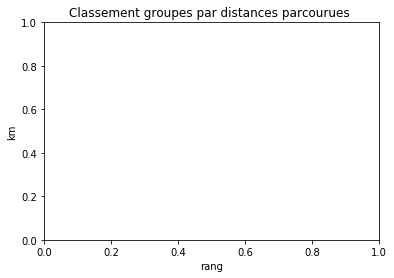

In [51]:


fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.set_title("Classement groupes par distances parcourues ")    
ax1.set_xlabel('rang')
ax1.set_ylabel('km')
ax1.plot(sorted(resultsGlobalYears,key=int),resultsGlobalYears[YearG]["toursGlobalLengthMAX"],'x' ,color='r', label="data['nom']")
ax1.set_autoscale_on
leg = ax1.legend()

plt.show()


In [55]:
with open("./tour_miner/"+"young-mc693097c4-17ec-4bb8-9b7c-74a5a2a85723"+".obj", 'rb') as handle:
    temp= pickle.load(handle)
    
print temp

{1: {'tourLength': 3, 'tourdist': 4412.095403569076, 'tourYear': 2013, 'tourdistOpt': 4412.095403569076}, 2: {'tourLength': 3, 'tourdist': 3598.3834783813863, 'tourYear': 2016, 'tourdistOpt': 3598.3834783813863}, 3: {'tourLength': 20, 'tourdist': 27289.99921420611, 'tourYear': 2016, 'tourdistOpt': 9304.647910861806}, 4: {'tourLength': 6, 'tourdist': 4892.130973463658, 'tourYear': 2016, 'tourdistOpt': 4892.130973463658}, 'name': u'Young MC', 6: {'tourLength': 8, 'tourdist': 7787.715648749957, 'tourYear': 2017, 'tourdistOpt': 6323.238414375028}, 7: {'tourLength': 31, 'tourdist': 73680.08716318749, 'tourYear': 2017, 'tourdistOpt': 46773.53267687943}, 8: {'tourLength': 4, 'tourdist': 2438.171813830467, 'tourYear': 2017, 'tourdistOpt': 2438.171813830467}, 9: {'tourLength': 10, 'tourdist': 16354.945789979454, 'tourYear': 2017, 'tourdistOpt': 10940.483749558794}, 10: {'tourLength': 8, 'tourdist': 8978.55589883757, 'tourYear': 2017, 'tourdistOpt': 15295.868189735194}, 'totalArtistOptTourDist':

In [6]:
with open("./RESULTSGLOBAL.obj", 'rb') as handle:
          temp= pickle.load( handle)
print temp

{'manOpt': 0.23255376595961377, 'autoOpt': 0.21995298276047787, 'totalOptDistsMin': 1639279100.4292355, 'totalOptDists': 1666194602.2991636, 'totalDists': 2136018170.0272305}


In [ ]:
***************************
TOTAL ARTISTS TOURS DISTS 2135250690.17 km
TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS 1665625398.71
TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS 1638787824.49
AUTO-OPTIMIZED BY  21.993918261  %
MANUALLY OPTIMIZED BY  23.2507999161  %
***************************

***************************
TOTAL ARTISTS TOURS DISTS 2136018170.03 km
TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS 1666994420.69
TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS 1640164490.57
AUTO-OPTIMIZED BY  21.9578539134  %
MANUALLY OPTIMIZED BY  23.2139260994  %
***************************


In [ ]:
***************************
TOTAL ARTISTS TOURS DISTS 2297461485.47 km
TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS 1666777181.22
TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS 1644324623.69
AUTO-OPTIMIZED BY  27.4513548211  %
MANUALLY OPTIMIZED BY  28.4286315965  %
***************************

In [ ]:
***************************
TOTAL ARTISTS TOURS DISTS 2253720578.74
TOTAL AUTO OPTIMIZED ARTISTS TOURS DISTS 1638593722.15
TOTAL MANUALLY OPTIMIZED ARTISTS TOURS DISTS 1617040685.03
AUTO-OPTIMIZED BY  27.2938385706  %
MANUALLY OPTIMIZED BY  28.2501699508  %
***************************
